In [1]:
#%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")

## Setting max displayed rows to 500, in order to display the full output of any command
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Setting to avoid scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# pour que les valeurs infinies soient considérées aussi comme des NaN :
pd.options.mode.use_inf_as_na = True

# sklearn
from sklearn.metrics import *

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/pandas/compat/__init__.py:109: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Rajout des données
## Calul des ratios

### A faire :
- renommer les colonnes avec les codifications cerfa (sous forme de dictionnaire). Réfléchir à la façon dont les infos seront ensuite récupérées depuis l'UI (formulaire ? scan des données ? Prévoir de rajouter à chaque fois les infos dans la db ? => visiblement non, la DB utilisée seulement pour entrainer le modèle)
- distinguer les types de variables (bilan, cdr, autres infos...). => OK
- créer les variables "ratios" (les nommer R1, R2...)
- les mettre en DB (à quel moment ?)
- distinguer les variables qualitatives et quantitatives


- prendre tous les ratios + certains champs en valeur. Pour déterminer les champs en valeur à prendre, calculer les corrélations + faire graphes + Feature Importance.

- penser à travailler sur les résidus (rajouter des modèles les uns sur les autres)



- Prévoir dans la DB une table pour les ratios, une autre pour le bilan, une pour le CDR... Réfléchir au meilleur schéma. Prévoir une table avec les types d'entreprises. Prévoir une table indiquant les types de données : CDR, bilan... ? 


In [2]:
df = pd.read_csv("../data/data_used/total.csv")

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df.shape

(9750, 104)

In [4]:
def calcul_ratios(df):
    df["Credit client"] = (df['Clients et comptes rattachés (3) (net) (BXNET) 2016 (€)']*365)/(df["Chiffre d'affaires net (Total) (FL) 2016 (€)"]*1.2)

    df["Credit Fournisseurs"] = df['Dettes fournisseurs et comptes rattachés (DX) 2016 (€)']*365/(
        (df['Achats de marchandises (y compris droits de douane) (FS) 2016 (€)'] 
        + df['Achats de matières premières et autres approvisionnements (y compris droits de douane) (FU) 2016 (€)'] 
        + df['Autres achats et charges externes (3) (6 bis) (FW) 2016 (€)']
        )*1.2)

    df["Rotation_stocks"] = ( df['Matières premières, approvisionnements (net) (BLNET) 2016 (€)'] + 
             + df['En cours de production de biens (net) (BNNET) 2016 (€)'] 
             + df['En cours de production de services (net) (BPNET) 2016 (€)']
             + df['Produits intermédiaires et finis (net) (BRNET) 2016 (€)']
             + df['Marchandises (net) (BTNET) 2016 (€)'])*365 / (
                df["Chiffre d'affaires net (Total) (FL) 2016 (€)"]  
                - df["1 - RESULTAT D'EXPLOITATION (I - II) (GG) 2016 (€)"])

    df["BFR"] = (
        df['TOTAL (III) (net) (CJNET) 2016 (€)']
        + df['Valeurs mobilières de placement (net) (CDNET) 2016 (€)']
        + df['Disponibilités (net) (CFNET) 2016 (€)']
        - df['Avances et acomptes reçus sur commandes en cours (DW) 2016 (€)']
        - df['Dettes fournisseurs et comptes rattachés (DX) 2016 (€)']
        - df['Dettes fiscales et sociales (DY) 2016 (€)']
        - df['Dettes sur immobilisations et comptes rattachés (DZ) 2016 (€)']
        - df['Autres dettes (EA) 2016 (€)']
        - df["Produits constatés d'avance (EB) 2016 (€)"])


    df["BFRE"] = (
                df['Matières premières, approvisionnements (net) (BLNET) 2016 (€)']
                 + df['En cours de production de services (net) (BPNET) 2016 (€)']
                 + df['En cours de production de biens (net) (BNNET) 2016 (€)']
                 + df['Produits intermédiaires et finis (net) (BRNET) 2016 (€)']
                 + df['Marchandises (net) (BTNET) 2016 (€)']
                 + df['Avances et acomptes versés sur commandes (net) (BVNET) 2016 (€)']
                 + df['Clients et comptes rattachés (3) (net) (BXNET) 2016 (€)']
                - df['Avances et acomptes reçus sur commandes en cours (DW) 2016 (€)']
                - df['Dettes fournisseurs et comptes rattachés (DX) 2016 (€)']
                - df['Dettes fiscales et sociales (DY) 2016 (€)']
                - df['Autres dettes (EA) 2016 (€)']
                 )

    df["Endettement total"] = (df['Autres emprunts obligataires (DT) 2016 (€)']
                 + df['Emprunts obligataires convertibles (DS) 2016 (€)']
                 + df['Emprunts et dettes auprès des établissements de crédit (5) (DU) 2016 (€)']
                 + df['Emprunts et dettes financières divers (DV) 2016 (€)']
                - df['(5)\xa0Dont concours bancaires courants, et soldes créditeurs de banques et CCP (EH) 2016 (€)'])

    df["CAF"] = (df['3 - RESULTAT COURANT AVANT IMPOTS (I - II + III - IV + V - VI) (GW) 2016 (€)']
                - df['Reprises sur amortissements et provisions, transferts de charges (9) (FP) 2016 (€)']
                + df["Dotations d'exploitation sur immobilisations (dotations aux amortissements) (GA) 2016 (€)"]
                + df["Dotations d'exploitation sur immobilisations (dotations aux provisions) (GB) 2016 (€)"]
                + df["Dotations d'exploitation sur actif circulant (dotations aux provisions) (GC) 2016 (€)"]
                + df["Dotations d'exploitation pour risques et charges (dotations aux provisions) (GD) 2016 (€)"]
                - df['Reprises sur provisions & transferts de charges (GM) 2016 (€)']
                + df['Dotations financières aux amortissements et provisions (GQ) 2016 (€)']
                - df["Participation des salariés aux résultats de l'entreprise (HJ) 2016 (€)"]
                - df['Impôts sur les bénéfices (HK) 2016 (€)'])

    df["Capacite de remboursement"] = df["Endettement total"] / df["CAF"]


    df["Ressources durables"] = (df['TOTAL (I) (DL) 2016 (€)']
                 + df['TOTAL(II) (DO) 2016 (€)']
                 + df['TOTAL (III) (DR) 2016 (€)']
                 + df['Autres emprunts obligataires (DT) 2016 (€)']
                 + df['Emprunts obligataires convertibles (DS) 2016 (€)']
                 + df['Emprunts et dettes auprès des établissements de crédit (5) (DU) 2016 (€)']
                 + df['Emprunts et dettes financières divers (DV) 2016 (€)']
                 - df['(5)\xa0Dont concours bancaires courants, et soldes créditeurs de banques et CCP (EH) 2016 (€)']
                 - df['Capital souscrit non appelé (I) (AA) 2016 (€)'])


    df["FRNG"] = (df["Ressources durables"]   
                 + df['Ecarts de conversion passif (V) (ED) 2016 (€)']
                 - df['Primes de remboursement des obligations (CM) 2016 (€)']
                 - df['Ecarts de conversion actif (CN) 2016 (€)']
                 + df['TOTAL (II) (net) (BJNET) 2016 (€)'])

    df["Taux endettement"] = df["Endettement total"] / df["Ressources durables"]

    df["Rentabilite financiere"] = (df["RESULTAT DE L'EXERCICE (bénéfice ou perte) (DI) 2016 (€)"] 
                                    / (df['TOTAL (I) (DL) 2016 (€)'] 
                                       - df['Capital souscrit non appelé (I) (AA) 2016 (€)']))

    df["EBE"] = (df["Chiffre d'affaires net (Total) (FL) 2016 (€)"]
                + df["Subventions d'exploitation (FO) 2016 (€)"]
                + df['Production stockée (FM) 2016 (€)']
                + df['Production immobilisée (FN) 2016 (€)']
                - df['Achats de marchandises (y compris droits de douane) (FS) 2016 (€)']
                - df['Variation de stock (marchandises) (FT) 2016 (€)']
                - df['Achats de matières premières et autres approvisionnements (y compris droits de douane) (FU) 2016 (€)']
                - df['Variation de stock (matières premières et approvisionnements) (FV) 2016 (€)']
                - df['Autres achats et charges externes (3) (6 bis) (FW) 2016 (€)']
                - df['Impôts, taxes et versements assimilés (FX) 2016 (€)']
                - df['Salaires et traitements (FY) 2016 (€)']
                - df['Charges sociales (10) (FZ) 2016 (€)']
                + df['(3)\xa0Dont Crédit-bail mobilier (HP) 2016 (€)']
                + df['(3)\xa0Dont Crédit-bail immobilier (HQ) 2016 (€)']
                )

    df["VA"] = (df["EBE"] 
                - df["Subventions d'exploitation (FO) 2016 (€)"]
                + df['Impôts, taxes et versements assimilés (FX) 2016 (€)']
                + df['Salaires et traitements (FY) 2016 (€)']
                + df['Charges sociales (10) (FZ) 2016 (€)'])

    df["Liquidite generale"] = ((df['TOTAL (III) (net) (CJNET) 2016 (€)']
                               - df["Charges constatées d'avance (3) (net) (CHNET) 2016 (€)"])
                               / (df['Avances et acomptes reçus sur commandes en cours (DW) 2016 (€)']
                                 + df['Dettes fournisseurs et comptes rattachés (DX) 2016 (€)']
                                 + df['Dettes fiscales et sociales (DY) 2016 (€)']
                                 + df['Dettes sur immobilisations et comptes rattachés (DZ) 2016 (€)']
                                 + df['Autres dettes (EA) 2016 (€)']
                                 + df['(5)\xa0Dont concours bancaires courants, et soldes créditeurs de banques et CCP (EH) 2016 (€)']))


    df["Liquidite reduite"] = (
        (
            (df['TOTAL (III) (net) (CJNET) 2016 (€)']
                               - df["Charges constatées d'avance (3) (net) (CHNET) 2016 (€)"]
            )
                               - (
                                   df['Matières premières, approvisionnements (net) (BLNET) 2016 (€)']
                                 + df['En cours de production de services (net) (BPNET) 2016 (€)']
                                 + df['En cours de production de biens (net) (BNNET) 2016 (€)']
                                 + df['Produits intermédiaires et finis (net) (BRNET) 2016 (€)']
                                 + df['Marchandises (net) (BTNET) 2016 (€)']
                                 )
        ) 
                                / (
                                    df['Avances et acomptes reçus sur commandes en cours (DW) 2016 (€)']
                                 + df['Dettes fournisseurs et comptes rattachés (DX) 2016 (€)']
                                 + df['Dettes fiscales et sociales (DY) 2016 (€)']
                                 + df['Dettes sur immobilisations et comptes rattachés (DZ) 2016 (€)']
                                 + df['Autres dettes (EA) 2016 (€)']
                                 + df['(5)\xa0Dont concours bancaires courants, et soldes créditeurs de banques et CCP (EH) 2016 (€)']
                                    )
                                )

    df["Taux ressources propres"] = ((df['TOTAL (I) (DL) 2016 (€)'] 
                                     - df['Capital souscrit non appelé (I) (AA) 2016 (€)'])
                                    / df['TOTAL GENERAL (I à V) (EE) 2016 (€)'])

    #df["CA par employe"] = gérer les 0

    df["Rentabilite des capitaux propres"] = (df["RESULTAT DE L'EXERCICE (bénéfice ou perte) (DI) 2016 (€)"]
                                             / (df['TOTAL (I) (DL) 2016 (€)']
                                                + df['TOTAL(II) (DO) 2016 (€)']
                                                - df['Capital souscrit non appelé (I) (AA) 2016 (€)']))

    df["Autonomie financiere"] = ((df['TOTAL (I) (DL) 2016 (€)']
                                                + df['TOTAL(II) (DO) 2016 (€)']
                                                - df['Capital souscrit non appelé (I) (AA) 2016 (€)'])
                                  / df['TOTAL GENERAL (I à V) (EE) 2016 (€)'])

    df["Poids interets"] = (df['Intérêts et charges assimilées (GR) 2016 (€)'] 
                            / df["1 - RESULTAT D'EXPLOITATION (I - II) (GG) 2016 (€)"])

    df["Taux EBE"] = (df["EBE"]
                      / df["Chiffre d'affaires net (Total) (FL) 2016 (€)"])

    df["Taux VA"] = (df["VA"]
                      / df["Chiffre d'affaires net (Total) (FL) 2016 (€)"])

    df["Taux Rentabilite"] = (df["RESULTAT DE L'EXERCICE (bénéfice ou perte) (DI) 2016 (€)"]
                             / df["Chiffre d'affaires net (Total) (FL) 2016 (€)"])

    df["Poids dettes fiscales"] = ((df['Sécurité sociale et autres organismes sociaux - Montant brut (8D) 2016 (€)']
                                   + df['Impôts sur les bénéfices - Montant brut (8E) 2016 (€)']
                                   + df['T.V.A. - Montant brut (VW) 2016 (€)'])
                                   / df["Chiffre d'affaires net (Total) (FL) 2016 (€)"])


    df["Taux augmentation endettement CT"] = (df['Emprunts souscrits en cours d’exercice - à 1 an au plus (VJ2) 2016 (€)']
                                         / df['TOTAL GENERAL (I à V) (EE) 2016 (€)'])

    df["Tresorerie"] = df["FRNG"] - df["BFR"]
    
    return df

In [5]:
df = calcul_ratios(df)

In [6]:
df.shape

(9750, 130)

## Merge avec données NAF

In [7]:
def merge_naf(df, naf_path):
    df_naf = pd.read_excel(naf_path, header=[1])
    df_naf = df_naf.drop(["Unnamed: 10", "Unnamed: 11", "Unnamed: 12", "Unnamed: 13", "Unnamed: 14", "Unnamed: 15",
            "Unnamed: 16", "Unnamed: 17", "Unnamed: 18", "Unnamed: 19", "Unnamed: 20", "Unnamed: 21", "Unnamed: 22"], axis=1)
    df_naf = df_naf.rename(columns={'Unnamed: 1':'Descriptif A 732'})
    # Step 1 - suppression des points dans la colonne A 732
    # pour avoir le même format que dans les données d'entreprises
    for row in range(df_naf.shape[0]):
        df_naf.loc[row,'A 732'] = df_naf.loc[row,'A 732'].replace('.', '')
    # Step 2 - Join avec le dataset d'entreprises 
    # (pour la mise en DB, il faudra créér deux tables et faire les joins dans la requête SQL)
    df_merged = pd.merge(df, df_naf, how = 'left', left_on = df['Code APE'], right_on = df_naf['A 732'])
    df_merged = df_merged.drop(['key_0'], axis=1)
    assert df_merged.shape[0]==df.shape[0]
    assert df_merged.shape[1]==df.shape[1]+df_naf.shape[1]
    return df_merged, df_naf

In [8]:
df, df_naf = merge_naf(df, naf_path="../data/data_used/table_nAF2-NA.xls")

In [9]:
df.shape

(9750, 140)

## Date de création => rajout d'une colonne sur l'âge

In [10]:
import datetime
def ajout_col_age(df):
    df["Date de création"] = pd.to_datetime(df["Date de création"])
    df["Age entreprise"] = ((datetime.datetime(2019,12,31) - df["Date de création"])/np.timedelta64(1, 'M'))
    df["Age entreprise"] = df["Age entreprise"].astype(int)
    return df

In [11]:
df = ajout_col_age(df)

## Suppression des colonnes absolument inutiles
- Supprimer toutes les colonnes qui sont intégrées dans les ratios et qui ne servent qu'à cela :
- Supprimer toutes les colonnes qui 


### Définition des catégories de colonnes

In [12]:
target_col = ['default']

In [13]:
#naf_cols = df_naf.columns.to_list()
naf_cols = ['A 732',
 'Descriptif A 732',
 'A 615',
 'A 272',
 'A 129',
 'A 88',
 'A 64',
 'A 38',
 'A 21',
 'A 10']
naf_cols_to_drop = ['A 732',
 'Descriptif A 732',
 'A 615',
 'A 272',
 'A 129',
 'A 88',
 'A 64',
 'A 38']
naf_cols_to_keep = [col for col in naf_cols if col not in naf_cols_to_drop]
naf_cols_to_keep

['A 21', 'A 10']

In [14]:
general_cols = ['SIREN', 
           'Dénomination', 
           'SIRET', 
           'Code APE', 
           'Procédures collectives (type)', 
           'Procédures collectives (date)', 
           'Code postal', 
           'Date de création', 
            'Age entreprise', 
           'Tranche effectifs', 
           'Catégorie juridique (Niveau I)', 
           'Ville', 
           "Nombre de mois de l'exercice comptable 2016", 
           'Notation NOTA-PME 2016', 
           'Catégorie juridique (Niveau II)',
            'Effectif moyen du personnel (YP) 2016']

general_cols_to_drop = ['SIREN', 
           'Dénomination', 
           'SIRET', 
           'Code APE', # présent dans les colonnes NAF (A 732)            
           'Procédures collectives (type)', 
           'Procédures collectives (date)', 
           'Code postal', # à reprendre après pour analyse géographique
           'Date de création', 
           'Ville',
                        
           'Notation NOTA-PME 2016', 
            'Catégorie juridique (Niveau I)',
           'Catégorie juridique (Niveau II)',
            'Effectif moyen du personnel (YP) 2016']

general_cols_to_keep = [col for col in general_cols if col not in general_cols_to_drop]
general_cols_to_keep

['Age entreprise',
 'Tranche effectifs',
 "Nombre de mois de l'exercice comptable 2016"]

In [15]:
important_cols = ['TOTAL (I) (DL) 2016 (€)',
                    "Chiffre d'affaires net (Total) (FL) 2016 (€)",
                    '3 - RESULTAT COURANT AVANT IMPOTS (I - II + III - IV + V - VI) (GW) 2016 (€)',
                    'TOTAL GENERAL(I à VI) (net) (CONET) 2016 (€)']

In [16]:
bilan_cols = ['Capital souscrit non appelé (I) (AA) 2016 (€)', 
         'TOTAL (II) (net) (BJNET) 2016 (€)', 
         'Matières premières, approvisionnements (net) (BLNET) 2016 (€)', 
         'En cours de production de biens (net) (BNNET) 2016 (€)', 
         'En cours de production de services (net) (BPNET) 2016 (€)', 
         'Produits intermédiaires et finis (net) (BRNET) 2016 (€)', 
         'Marchandises (net) (BTNET) 2016 (€)', 
         'Avances et acomptes versés sur commandes (net) (BVNET) 2016 (€)', 
         'Clients et comptes rattachés (3) (net) (BXNET) 2016 (€)', 
         'Autres créances (3) (net) (BZNET) 2016 (€)', 
         'Capital souscrit et appelé, non versé (net) (CBNET) 2016 (€)', 
         'Valeurs mobilières de placement (net) (CDNET) 2016 (€)', 
         'Disponibilités (net) (CFNET) 2016 (€)', 
         "Charges constatées d'avance (3) (net) (CHNET) 2016 (€)", 
         'TOTAL (III) (net) (CJNET) 2016 (€)', 
         'Primes de remboursement des obligations (CM) 2016 (€)', 
         'Ecarts de conversion actif (CN) 2016 (€)', 
         'TOTAL GENERAL(I à VI) (net) (CONET) 2016 (€)', 
         'Capital social ou individuel (1) (DA) 2016 (€)', 
         'Report à nouveau (DH) 2016 (€)', 
         "RESULTAT DE L'EXERCICE (bénéfice ou perte) (DI) 2016 (€)", 
         'TOTAL (I) (DL) 2016 (€)', 
         'TOTAL(II) (DO) 2016 (€)', 
         'TOTAL (III) (DR) 2016 (€)', 
         'Autres emprunts obligataires (DT) 2016 (€)', 
         'Emprunts obligataires convertibles (DS) 2016 (€)', 
         'Emprunts et dettes auprès des établissements de crédit (5) (DU) 2016 (€)', 
         'Emprunts et dettes financières divers (DV) 2016 (€)', 
         'Avances et acomptes reçus sur commandes en cours (DW) 2016 (€)', 
         'Dettes fournisseurs et comptes rattachés (DX) 2016 (€)', 
         'Dettes fiscales et sociales (DY) 2016 (€)', 
         'Dettes sur immobilisations et comptes rattachés (DZ) 2016 (€)', 
         'Autres dettes (EA) 2016 (€)', 
         "dont comptes courants d'associés de l'exercice N (EA2) 2016 (€)", 
         "Produits constatés d'avance (EB) 2016 (€)", 
         'TOTAL (IV) (EC) 2016 (€)', 
         'TOTAL GENERAL (I à V) (EE) 2016 (€)', 
         '(5)\xa0Dont concours bancaires courants, et soldes créditeurs de banques et CCP (EH) 2016 (€)',
         'Ecarts de conversion passif (V) (ED) 2016 (€)']

In [17]:
cdr_cols = ["Chiffre d'affaires net (France) (FJ) 2016 (€)", 
       "Chiffre d'affaires net (Exportations et livraisons intracommunautaires) (FK) 2016 (€)", 
       "Chiffre d'affaires net (Total) (FL) 2016 (€)", 
       "Subventions d'exploitation (FO) 2016 (€)", 
       'Reprises sur amortissements et provisions, transferts de charges (9) (FP) 2016 (€)', 
       "Total des produits d'exploitation (2) (I) (FR) 2016 (€)", 
       'Achats de marchandises (y compris droits de douane) (FS) 2016 (€)', 
       'Variation de stock (marchandises) (FT) 2016 (€)', 
       'Achats de matières premières et autres approvisionnements (y compris droits de douane) (FU) 2016 (€)', 
       'Variation de stock (matières premières et approvisionnements) (FV) 2016 (€)', 
       'Autres achats et charges externes (3) (6 bis) (FW) 2016 (€)', 
       'Impôts, taxes et versements assimilés (FX) 2016 (€)', 
       'Salaires et traitements (FY) 2016 (€)', 
       'Charges sociales (10) (FZ) 2016 (€)', 
       "Dotations d'exploitation sur immobilisations (dotations aux amortissements) (GA) 2016 (€)", 
       "Dotations d'exploitation sur immobilisations (dotations aux provisions) (GB) 2016 (€)", 
       "Dotations d'exploitation sur actif circulant (dotations aux provisions) (GC) 2016 (€)", 
       "Dotations d'exploitation pour risques et charges (dotations aux provisions) (GD) 2016 (€)", 
       'Autres charges (12) (GE) 2016 (€)', 
       "Total des charges d'exploitation (4) (II) (GF) 2016 (€)", 
       "1 - RESULTAT D'EXPLOITATION (I - II) (GG) 2016 (€)", 
       'Total des produits financiers (V) (GP) 2016 (€)', 
       'Intérêts et charges assimilées (GR) 2016 (€)', 
       'Total des charges financières (VI) (GU) 2016 (€)', 
       'Dotations financières aux amortissements et provisions (GQ) 2016 (€)', 
       'Reprises sur provisions & transferts de charges (GM) 2016 (€)', 
       'Total des produits exceptionnels (VII) (HD) 2016 (€)', 
       'Reprises sur provisions & transferts de charges (HC) 2016 (€)', 
       'Dotations exceptionnelles aux amortissements et provisions (6 ter) (HG) 2016 (€)', 
       'Total des charges exceptionnelles (VIII) (HH) 2016 (€)', 
       '4 - RESULTAT EXCEPTIONNEL (VII - VIII) (HI) 2016 (€)', 
       '5 - BENEFICE OU PERTE (Total des produits - total des charges) (HN) 2016 (€)', 
       "Participation des salariés aux résultats de l'entreprise (HJ) 2016 (€)", 
       'Impôts sur les bénéfices (HK) 2016 (€)',
       'Production stockée (FM) 2016 (€)', 
       'Production immobilisée (FN) 2016 (€)',
       '(3)\xa0Dont Crédit-bail mobilier (HP) 2016 (€)', 
       '(3)\xa0Dont Crédit-bail immobilier (HQ) 2016 (€)', 
       '3 - RESULTAT COURANT AVANT IMPOTS (I - II + III - IV + V - VI) (GW) 2016 (€)']

In [18]:
annexes_cols = ['Clients douteux ou litigieux - Montant brut (VA) 2016 (€)', 
           'Sécurité sociale et autres organismes sociaux - Montant brut (8D) 2016 (€)', 
           'Impôts sur les bénéfices - Montant brut (8E) 2016 (€)', 
           'T.V.A. - Montant brut (VW) 2016 (€)', 
           'Emprunts remboursés en cours d’exercice (VK) 2016 (€)', 
           'Emprunts souscrits en cours d’exercice - à 1 an au plus (VJ2) 2016 (€)', 
           "Emprunts souscrits en cours d’exercice - à plus d'un an et 5 ans au plus (VJ3) 2016 (€)", 
           'Emprunts souscrits en cours d’exercice - à plus de 5 ans (VJ4) 2016 (€)', 
           'Effets portés à l’escompte et non échus (YS) 2016 (€)', 
           'Sous‐traitance (YT) 2016 (€)']

In [19]:
ratios_cols = ['Credit client',
 'Credit Fournisseurs',
 'Rotation_stocks',
 'BFR',
 'BFRE',
 'Endettement total',
 'CAF',
 'Capacite de remboursement',
 'Ressources durables',
 'FRNG',
 'Taux endettement',
 'Rentabilite financiere',
 'EBE',
 'VA',
 'Liquidite generale',
 'Liquidite reduite',
 'Taux ressources propres',
 'Rentabilite des capitaux propres',
 'Autonomie financiere',
 'Poids interets',
 'Taux EBE',
 'Taux VA',
 'Taux Rentabilite',
 'Poids dettes fiscales',
 'Taux augmentation endettement CT',
 'Tresorerie']

In [20]:
cols_to_keep = (ratios_cols 
                + target_col 
                + general_cols_to_keep 
                + important_cols
                + naf_cols_to_keep)
print(len(cols_to_keep))

36


In [21]:
df.shape

(9750, 141)

# Analyse de la forme du dataset dans sa totalité
#### Analyse de Forme :
- **variable target** : default (1 si défaillante, 0 sinon)
- **lignes et colonnes** : 9750, 130
- **types de variables** : quantitatives : 120, qualitatives : 10
- **Analyse des valeurs manquantes** :
    - très peu de NaN (2.47% au total). C'est normal vu que l'essentiel des données constituent des champs obligatoires de la déclaration fiscale. Et que si ces champs ne sont pas renseignés les valeurs ne sont pas considérées comme manquantes mais comme nulles. Pour les champs numériques obligatoires (CA, achats, stocks...) c'est le cas. Mais **pour d'autres (une grande partie des champs de la liste "general"), il faudra se pencher sur le nombre de zéros**.
    - NaN sur des infos complémentaires ("vrais" NaN) :
        - Catégorie juridique (Niveau I) => 91% de NaN / Se complète avec Catégorie juridique (Niveau II) => 9% de NaN => Il faudra probablement regrouper ces 2 colonnes en une seule, ou bien en supprimer les données. Provient d'une erreur dans la constitution de l'échantillon
        - Procédures collectives (type et date) : NaN pour 63% des entreprises, ce qui est normal car ne concerne que les entreprises en difficulté. Il faudra voir la meilleure façon de le prendre en compte
    - NaN sur les ratios (causés dans la plupart des cas par des valeurs nulles au dénominateur, à évaluer au cas par cas)
        - Poids des intérêts, taux de VA et taux d'EBE : On a 16% de NaN. Ces 3 ratios ayant en commun d'avoir le CA au dénominateur, il est probable que le CA soit nul pour 16% des entreprises. A creuser.
        - Poids des dettes fiscales : 13.9% de NaN. Devrait correspondre à des entreprises dont le total du bilan est nul ?
        
- **Entreprises avec un CA = 0**

In [22]:
df.shape

(9750, 141)

### Analyse des types de variables


In [23]:
# identifier le nombre de variables catégorielles et numériques
df.dtypes.value_counts()

int64             103
float64            21
object             16
datetime64[ns]      1
dtype: int64

<AxesSubplot:ylabel='None'>

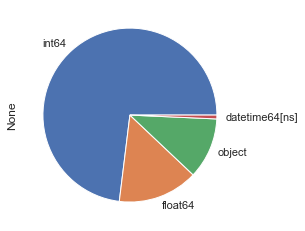

In [24]:
df.dtypes.value_counts().plot.pie()

### Variables catégorielles
- Seulement 10 variables sont catégorielles. Parmi elles :
    - Variables à supprimer (nombre de modalités trop important ou pas assez, ne permettant pas d'apporter ) : ["Dénomination", "Procédures collectives (type)", "Procédures collectives (date)", "Ville", "Notation NOTA-PME 2016"]
    - Tranches d'effectifs : 14. A conserver. Peut-être à imputer ? Faire le lien avec le nombre de salariés
    - Code APE : 534 valeurs uniques c'est trop. Prendre une table de correspondance INSEE pour réduire le champ (NA 38 ?)
    - Ville : pour l'instant à supprimer. Voir ultérieurement si ça peut être pertinent de travailler dessus (nombre d'habitants dans la ville ou bien rayon autour...)
    - Date de création : passer en format date. Peut-être le remplacer par le nombre d'années d'ancienneté
    - Catégorie juridique : soit supprimer les données, soit imputer les valeurs manquantes de la categ de niveau II
    - A noter pour plus tard :
        - Mettre en lien la ville avec le nombre d'habitants, la présence ou non d'une aire urbaine...
        - Préciser la catégorie juridique de niveau II

In [25]:
# identifier le nombre de modalités pour les variables catégorielles
for col in df.select_dtypes('object').columns:
    print(col, len(df[col].value_counts()))

Dénomination 9651
Code APE 534
Procédures collectives (type) 820
Procédures collectives (date) 3386
Tranche effectifs 14
Catégorie juridique (Niveau I) 4
Ville 3805
Notation NOTA-PME 2016 102
Catégorie juridique (Niveau II) 13
A 732 534
Descriptif A 732 534
A 129 110
A 64 57
A 38 33
A 21 18
A 10 10


In [26]:
# identifier les modalités prises par les variables catégorielles affichant moins de 20 modalités
categ = ["Tranche effectifs", "Catégorie juridique (Niveau I)", "Catégorie juridique (Niveau II)"]
for col in categ:
    print(f'{col :-<30} {df[col].unique()}')

Tranche effectifs------------- ['De 1000 à 1999 salariés' 'De 3 à 5 salariés' 'De 500 à 999 salariés'
 'De 100 à 199 salariés' 'De 200 à 249 salariés' 'De 250 à 499 salariés'
 'De 50 à 99 salariés' 'De 10 à 19 salariés' 'De 1 à 2 salariés'
 'De 20 à 49 salariés' "0 salarié pendant l'année"
 "0 salarié à la fin de l'année" nan 'De 6 à 9 salariés'
 'De 2000 à 4999 salariés']
Catégorie juridique (Niveau I) ['Société commerciale' 'Entrepreneur individuel'
 'Autre personne morale immatriculée au RCS'
 'Personne morale de droit étranger' nan]
Catégorie juridique (Niveau II) [nan "Société anonyme à conseil d'administration"
 'Société par actions simplifiée' 'Société anonyme à directoire'
 'Société à responsabilité limitée (SARL)' 'Société en nom collectif'
 'Entrepreneur individuel' 'Société civile' 'Société en commandite'
 "Groupement d'intérêt économique" 'Société coopérative agricole'
 'Personne morale de droit étranger, immatriculée au RCS (registre du commerce et des sociétés)'
 'Société

**Tranche d'effectifs**
- variable ordinale, recherche des différentes modalités.
- choix d'utiliser Tranche d'effectif plutôt qu'effectif moyen du personnel
- pour l'imputation des valeurs manquantes (il y en a 1240 soit 12,7%) => plusieurs options. Soit le plus fréquent (ici tranche 2), soit info en tant que telle (mettre un -999 par ex), soit supprimer la colonne ou les lignes, soit imputer en utilisant les KNN.

In [27]:
# Choix entre effectif moyen du personnel et tranche d'effectifs => choix de tranche d'effectifs qui est davantage renseignée ()
df[['Effectif moyen du personnel (YP) 2016', "Tranche effectifs"]].describe(include='all')

Effectif moyen du personnel (YP) 2016  Tranche effectifs
count                              9750.00000               8510
unique                                    NaN                 14
top                                       NaN  De 1 à 2 salariés
freq                                      NaN               1607
mean                                  4.98913                NaN
std                                  55.70324                NaN
min                                   0.00000                NaN
25%                                   0.00000                NaN
50%                                   0.00000                NaN
75%                                   0.00000                NaN
max                                4417.00000                NaN

In [28]:
# variable ordinale, recherche des différentes modalités.
# pour l'imputation des valeurs manquantes (il y en a 1240 soit 12,7%) => plusieurs options. Soit le plus fréquent (ici tranche 2), soit info en tant que telle (mettre un -999 par ex), soit supprimer la colonne ou les lignes, soit imputer en utilisant les KNN.
df["Tranche effectifs"].value_counts()

De 1 à 2 salariés                1607
De 3 à 5 salariés                1386
De 10 à 19 salariés              1277
De 6 à 9 salariés                1197
De 20 à 49 salariés               937
0 salarié à la fin de l'année     903
0 salarié pendant l'année         766
De 50 à 99 salariés               243
De 100 à 199 salariés             117
De 250 à 499 salariés              31
De 200 à 249 salariés              28
De 500 à 999 salariés              12
De 1000 à 1999 salariés             4
De 2000 à 4999 salariés             2
Name: Tranche effectifs, dtype: int64

In [29]:
dic_effectif = { "0 salarié pendant l'année" : 0
                , "0 salarié à la fin de l'année" : 1
                , "De 1 à 2 salariés" : 2
                , "De 3 à 5 salariés" : 3
                , "De 6 à 9 salariés" : 4
                , "De 10 à 19 salariés" : 5
                , "De 20 à 49 salariés" : 6
                , "De 50 à 99 salariés" : 7
                , "De 100 à 199 salariés" : 8
                , "De 200 à 249 salariés" : 9
                , "De 250 à 499 salariés" : 10
                , "De 500 à 999 salariés" : 11
                , "De 1000 à 1999 salariés" : 12
                , "De 2000 à 4999 salariés" : 13 
}

### Valeurs manquantes

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8208 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8208 missing from current font.
  font.set_text(s, 0, flags=flags)


<AxesSubplot:>

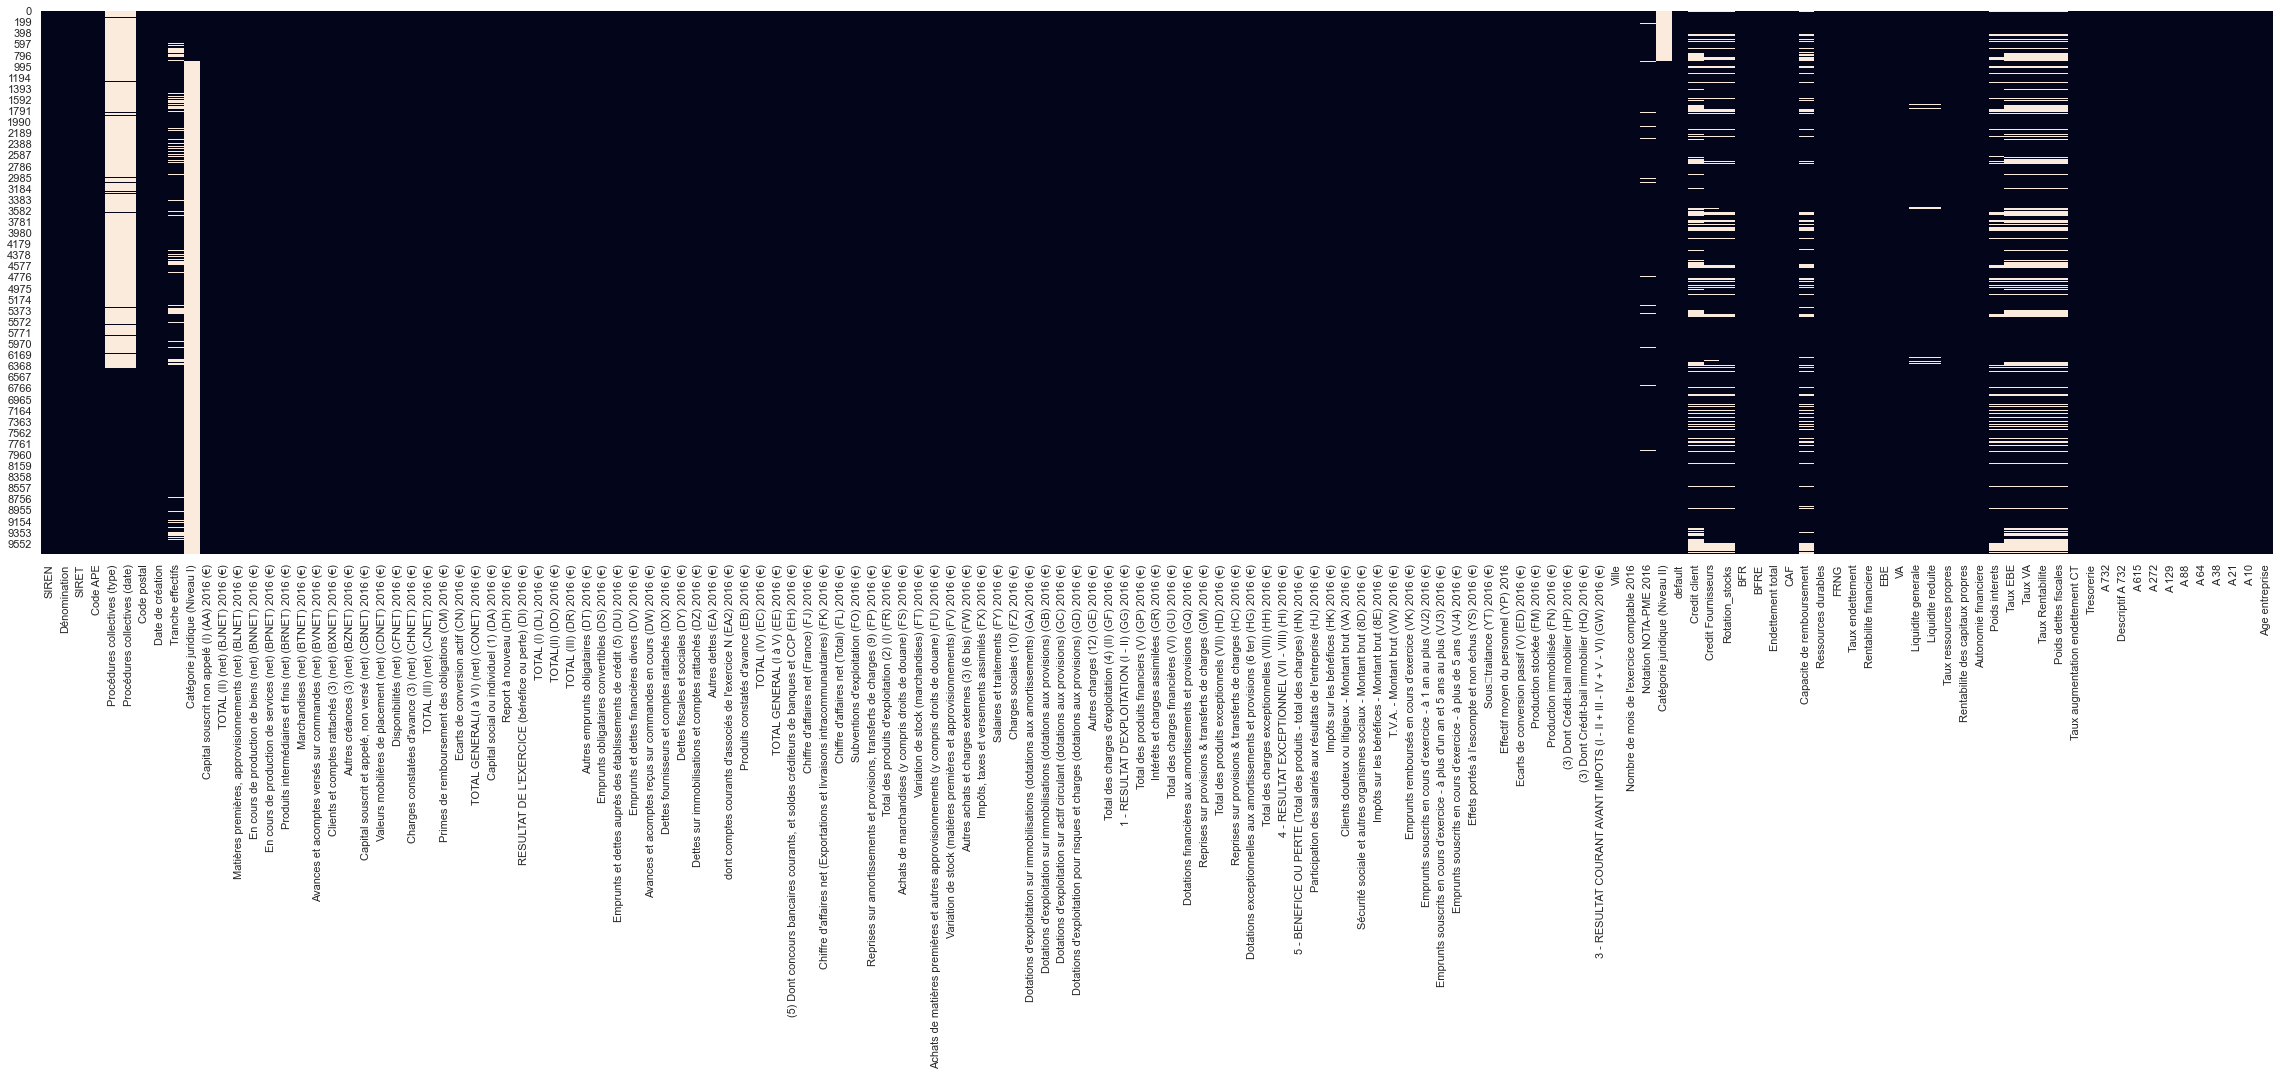

In [30]:
# heatmap des valeurs manquantes (en blanc)
plt.figure(figsize=(40,10))
sns.heatmap(df.isna(), cbar=False)

In [31]:
# total de NaN sur le dataset
df.isna().sum().sum()/(df.shape[0]*df.shape[1])*100

3.0503000545553736

In [32]:
# taux de NaN par colonne
(df.isna().sum()/df.shape[0]).sort_values(ascending=False)

Catégorie juridique (Niveau I)                                                                         0.90708
Procédures collectives (type)                                                                          0.63621
Procédures collectives (date)                                                                          0.63621
Taux Rentabilite                                                                                       0.23610
Poids dettes fiscales                                                                                  0.23610
Taux EBE                                                                                               0.23610
Taux VA                                                                                                0.23610
Credit client                                                                                          0.23610
Capacite de remboursement                                                                              0.18421
P

#### Focus sur les entreprises avec un CA null
- 2302 entreprises avec CA null (1541 saines et 761 défaillantes)
- Conséquence sur les ratios => 
- Est-ce pertinent de garder ces entreprises ? Comment reformuler cette question ? 
    - Est ce que la distribution (entre des entreprises ayant un CA nul et celle n'en ayant pas est significativement différente ?

In [33]:
CA_null = df[df["Chiffre d'affaires net (Total) (FL) 2016 (€)"]==0]

In [34]:
CA_not_null = df[df["Chiffre d'affaires net (Total) (FL) 2016 (€)"]!=0]

<AxesSubplot:xlabel="Chiffre d'affaires net (Total) (FL) 2016 (€)", ylabel='default'>

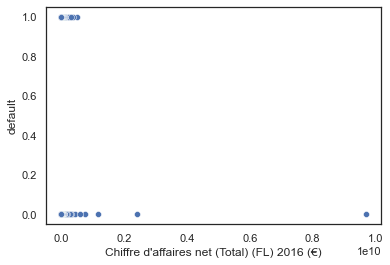

In [35]:
sns.scatterplot(x="Chiffre d'affaires net (Total) (FL) 2016 (€)", y= "default", data = df)

In [36]:
CA_null[target_col].value_counts()

default
0.00000    1541
1.00000     761
dtype: int64

# Baseline 0 : uniquement ratios cols, suppression des NaN
- Uniquement les ratio_cols
- Step 2 --> Gestion des NaN 
    - Suppression des lignes avec des valeurs nulles ou infinies (de 9750 à 7273 lignes) On vérifie que la part des saines/default est stable et c'est le cas : le taux d'entreprises en défault passe de 34.256% à 34.745%, on peut dire qu'il reste stable.
    - On a au final une df de 7273 lignes et 27 colonnes.

- AVANT Imputation
    - (9750, 27)
    - 0.00000   0.65744
    - 1.00000   0.34256


- APRES Imputation
    - (7273, 27)
    - 0.00000   0.65255
    - 1.00000   0.34745

- Step 3 --> Gestion des variables catégorielles
    - On n'a que des variables numériques (aucune variable catégorielle sur les ratios) => pas d'encodage à faire
    
- Step 4 --> Train test split

- Step 5 --> Modèle de régression logistique (attention c'est à ce niveau qu'est opéré le préprocessing de normalisation !!!)
    - Résultats :
- CONFUSION MATRIX __---__
          Predicted 0  Predicted 1  TOTAL
            0          944           18    962
            1          447           46    493
                       1391           64   1455

- CLASSIFICATION REPORT 
              precision    recall  f1-score   support

         0.0       0.68      0.98      0.80       962
         1.0       0.72      0.09      0.17       493

    
    
    - Interprétation des résultats :
    
- Sur les 493 positifs, seulement 46 ont été identifiés comme tels soit un recall de 0,09 ce qui est un très mauvais score. C'est pourtant essentiellement cette métrique que l'on cherche à améliorer
- Sur les 64 prédits positifs, 46 le sont réellement soit une précision de 0,72. On parvient ainsi à une accuracy de 0,66 et un F1 score de 0,17
- On cherche à accroitre le recall, en diminuant le nombre / la proportion de faux négatifs
=> Il semble que :
    - Soit le modèle n'est pas du tout adapté (modèle logistique - quelles sont les hypothèses derrière ?)
    - Soit le choix de features doit être revu (multicolinéarité ?)
    - Soit le préprocessing sur les features doit être revu (regarder les distributions des features, voir s'il est pertinent de normaliser avec la méthode employée, voir s'il est intéressant 
    - Soit (à la marge) les hyperparamètres du modèle doivent être revus 
        - notamment le threshold - voir https://kobia.fr/classification-metrics-precision-recall/ 
        - et le notebook sur les métriques de classification et les itérations, car on a un problème sur ce dernier plan : Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
    - Soit tout ça en même temps


**Suites à donner :**
1) tester rapidement 2-3 autres modèles différents (SVM et random forest par exemple) pour voir si le type de modèle a un impact

2) aller plus en profondeur sur les données

#### Suppression des NaN

In [ ]:
baseline = df.copy()
# sélection des colonnes à garder :
baseline = df[ratios_cols + target_col]

In [ ]:
#baseline_0 : enlève toutes les lignes avec des NaN ou des infinis en plus
def imputation_v0(df):
    # Baseline 0 - suppression des lignes avec des NaN
    df = df.replace([np.inf, -np.inf], np.nan) # remplacement des infinis par des nan pour les supprimer aussi
    df = df.dropna(axis=0)
    return df

In [ ]:
print("__---__ AVANT Imputation __---__")
print(baseline.shape)
print(baseline['default'].value_counts()/baseline.shape[0])
baseline = imputation_v0(baseline)
print("\n__---__ APRES Imputation __---__")
print(baseline.shape)
print(baseline['default'].value_counts()/baseline.shape[0])

In [ ]:
baseline.info()

#### Train test split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# on peut dans un premier temps séparer en 2 le dataset :
trainset, testset = train_test_split(baseline, test_size=0.2, random_state=0)

In [ ]:
# on vérifie que la distribution de la target reste OK dans les test et train set => c'est OK
trainset['default'].value_counts(normalize=True)

In [ ]:
testset['default'].value_counts(normalize=True)

#### Modèle + Normalisation
- Modèle 1 : normalisation + feature selection a priori (ratios + important features) ++ 
- Modèle 2 : normalisation + elastic net, garder initialement tous les features

In [ ]:
X_train = trainset.drop(["default"], axis=1)
y_train = trainset["default"]
X_test = testset.drop(["default"], axis=1)
y_test = testset["default"]

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression


model_1 = make_pipeline(StandardScaler(), LogisticRegression())

In [ ]:
# model_1.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
# la learning curve est indispensable pour identifier l'over ou l'under fitting
from sklearn.model_selection import learning_curve

def evaluation(model):
    
    # on entraine le modèle
    model.fit(X_train, y_train)
    # on fait les predictions
    y_pred = model.predict(X_test)
    
    # on fait la confusion_matrix
    conf = pd.DataFrame(confusion_matrix(y_test, y_pred))
    conf = conf.rename(columns={0: 'Predicted 0',1:'Predicted 1'})
    conf = conf.rename(index={0: 'Actual 0',1:"Actual 1"})
    conf["TOTAL"] = conf["Predicted 0"]+conf["Predicted 1"]
    conf = conf.append(pd.Series(conf.sum(axis=0), name="TOTAL"))

    
    print("__---__ CONFUSION MATRIX __---__")
    print(conf)
    print("\n__---__ CLASSIFICATION REPORT __---__")
    print(classification_report(y_test, y_pred))
    
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=4, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    # on visualise ca dans un graphique
    plt.figure(figsize=(12, 8))
    # évolu du train_score en fonction du nombre d'échantillons (N)
    # on prend le score_mean car on est en cross-val
    plt.plot(N, (1-train_score.mean(axis=1)), label='train score')
    plt.plot(N, (1-val_score.mean(axis=1)), label='validation score')
    plt.title("LEARNING CURVES")
    plt.legend()
    plt.xlabel("sample size")
    plt.ylabel("error (1 - F1 score)")
    
    

In [ ]:
evaluation(model_1)

**CONCLUSIONS - Points à retravailler :**
- Mieux gérer le workflow (voir avec ML Flow pour enregistrer les métadonnées des modèles en parallèle si possible)
- Garder par exemple un tableau avec date/noms des features/prépro (et paramètres)/modèle (et hyperparamètres) / résultat / commentaires
- Premier test avec régression logistique (ne pas oublier qu'on est en classification !!) => 0.66 ce qui n'est pas si bon que ça compte tenu de la répartition des 0 et des 1. Travailler sur la balance des classes pour voir s'il est possible d'améliorer les choses (SMOTE ?)
- Tester avec moins de features / random forest ?

# V_1 : test d'autres modèles avec les mêmes datas et le même prépro que la baseline 0

- modele 2 : random forest (pas besoin de scaler les données)
- modèle 3 : svm

Je garde les X, y et train/test de la baseline 0
Je définis simplement 2 autres modèles

Conclusions - dans le cas d'un decision tree, on s'améliore sensiblement sur le recall au détriment de la précision :

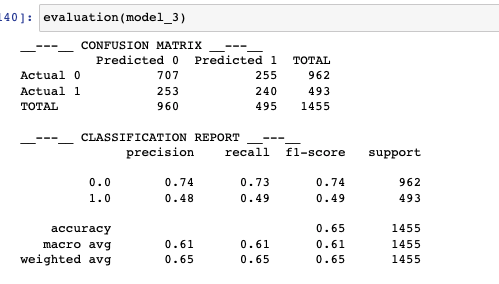

Dans le cas d'un random forest : attention il semble y avoir de l'overfitting

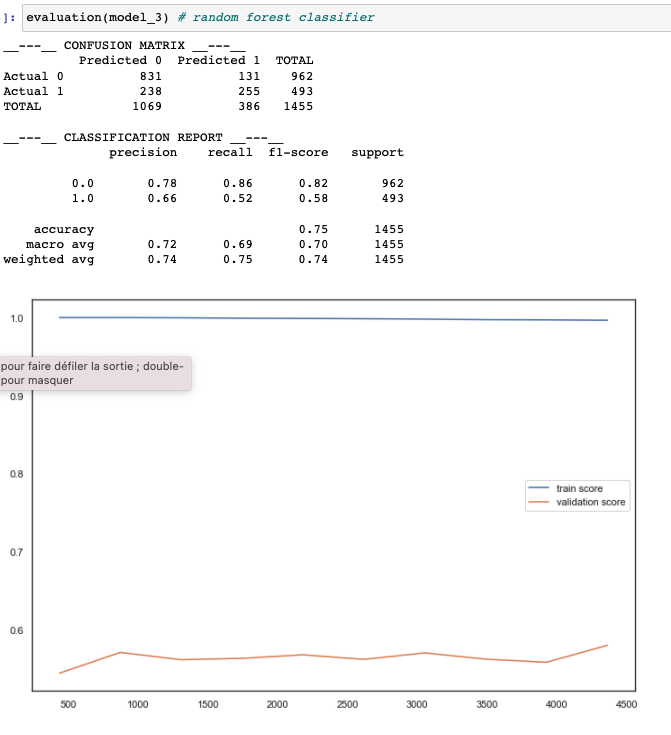

Dans le cas d'un SVM, on a à peu près les mêmes scores que pour la régression logistique :

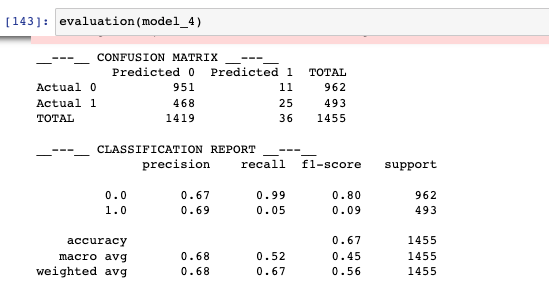

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

model_2 = DecisionTreeClassifier()
model_3 = RandomForestClassifier()
model_4 = make_pipeline(StandardScaler(),LinearSVC(random_state=0, tol=1e-5))

In [ ]:
evaluation(model_2)

In [ ]:
evaluation(model_4)

In [ ]:
evaluation(model_4)

In [ ]:
evaluation(model_3) # random forest classifier

# Autre tentative : garder tous les features et laisser la machine se débrouiller

In [ ]:
# mettre en paramètre de la fonction d'évaluation les datas pour le faire varier aussi

In [ ]:
df2 = df.copy()

In [ ]:
df2 = df2.select_dtypes(exclude=['object', 'datetime'])

In [ ]:
df2 = imputation_v0(df2)
X = df2.drop(["default"], axis=1)
y = df2["default"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

model_1 = make_pipeline(StandardScaler(),LogisticRegression())
model_2 = DecisionTreeClassifier()
model_3 = RandomForestClassifier()
model_4 = make_pipeline(StandardScaler(),LinearSVC(random_state=0, tol=1e-5))
model_5 = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=3))

In [ ]:
evaluation(model_1)

In [ ]:
evaluation(model_2)

In [ ]:
evaluation(model_3)

In [ ]:
evaluation(model_4)

In [ ]:
evaluation(model_5)

# Checklist n°2 - Personnalisée sur les 36 features sélectionnées
## Analyse d'ensemble
- NaN 
    - Suppression des lignes avec le CA null
    - 
- Variables qualitatives
    - Nombre de modalités
    - Etude de la relation de chaque variable à la target (violin/boxplot ? test statistique ?)
- Variables quantitatives
    - Analyse des distribitions => quelles transformations apporter ?
    - Identification des outliers
    - Identification des relations entre chacune des variables et la target (différence de distribution entre les 0 et les 1 : visualisation via histplot + test statistique ?)
    - Identification des relations entre les variables entre elles (multicolinéarité)

In [37]:
eda = df.copy()
eda = eda[cols_to_keep]
eda.shape

(9750, 36)

In [38]:
eda.dtypes.value_counts()

float64    18
int64      15
object      3
dtype: int64

In [39]:
eda['A 10'].describe()

count     9750
unique      10
top         GI
freq      3428
Name: A 10, dtype: object

In [40]:
eda.describe()

Credit client  Credit Fournisseurs  Rotation_stocks             BFR             BFRE  Endettement total             CAF  Capacite de remboursement  Ressources durables              FRNG  Taux endettement  Rentabilite financiere             EBE              VA  Liquidite generale  Liquidite reduite  Taux ressources propres  Rentabilite des capitaux propres  Autonomie financiere  Poids interets    Taux EBE    Taux VA  Taux Rentabilite  Poids dettes fiscales  Taux augmentation endettement CT        Tresorerie    default  Age entreprise  Nombre de mois de l'exercice comptable 2016  TOTAL (I) (DL) 2016 (€)  Chiffre d'affaires net (Total) (FL) 2016 (€)  3 - RESULTAT COURANT AVANT IMPOTS (I - II + III - IV + V - VI) (GW) 2016 (€)  TOTAL GENERAL(I à VI) (net) (CONET) 2016 (€)
count     7448.00000           8176.00000       8181.00000      9750.00000       9750.00000         9750.00000      9750.00000                 7954.00000           9750.00000        9750.00000        9739.00000              9736.00000      9750.00000      9750.00000          9671.00000         9671.00000               9742.00000                        9736.00000            9742.00000      8163.00000  7448.00000 7448.00000        7448.00000             7448.00000                        9742.00000        9750.00000 9750.00000      9750.00000                                   9750.00000               9750.00000                                    9750.00000                                         9750.00000                                                               9750.00000
mean       149.06680            259.49268       -111.92346   1160261.44328    -138878.79138      1364773.25559    148485.69303                   10.52217        3324615.28954     6020446.86174           0.78049                 0.16303    165818.44913    816577.11969            16.47997           14.30006                -45.95842                           0.14836             -45.95735        -0.57668    -0.50258    0.00780           0.00476                0.12127                           0.00000     4860185.41846    0.34256       219.78256                                     12.03426            1870661.46667                                 4018868.68749                                        68601.07395                                                            4776372.49097
std       4192.35762           5622.41391      30906.21852  11703360.05793    5857346.67824     29139180.32587   5273915.50670                  804.05827       64021697.24436   124758383.08204          23.35833                12.01459   6176247.16704  10695116.76626           389.07610          375.79302               4484.90658                          11.88507            4484.90659        29.69118    16.96251   13.79397          31.32679                2.89680                           0.00000   123433172.43328    0.47459       176.58743                                      0.72275           39104226.60941                               103138110.53327                                      4821236.84063                                                           68009461.46059
min         -0.39193         -12816.89876   -2650121.10577 -77080925.00000 -332866000.00000         -744.00000 -45609000.00000               -15558.33333    -1012887273.00000 -1012887273.00000       -1032.13333              -903.55102 -25508513.00000 -23264764.00000           -13.59083           -6.06870            -442652.81481                        -903.55102         -442652.81481     -2494.10938 -1103.89953 -944.98075        -903.12199               -0.00961                           0.00000 -1012887273.00000    0.00000        35.00000                                      1.00000        -1012887273.00000                                       0.00000                                    -79799577.00000                                                        -1001350437.00000
25%          2.85627             26.07302          0.00000      9179.25000   

### NaN

- Au total 5,5% de valeurs manquantes à l'échelle du dataset. 
- Un premier tour de visualisation des NaN permet d'identifier des strates où ils se concentrent. Il s'agit essentiellement de ratios, et c'est lié à la présence de CA nulls dans l'échantillon. 


**Focus sur les entreprises avec un CA null**
- 2302 entreprises avec CA null (1541 saines et 761 défaillantes)
- Est-ce pertinent de garder ces entreprises ? Comment reformuler cette question ? 
    - Est ce que la distribution (entre des entreprises ayant un CA nul et celle n'en ayant pas est significativement différente ?
    
- En supprimant les entreprises affichant un CA null, 
    - on voit bien que le taux de NaN diminue fortement : on passe de 5,5% à 0,36%.
    - la colonne "tranche d'effectifs" est à 10% de valeurs nulles.
    - le reste est de 1% et moins => on pourra imputer, la façon de le faire sera déterminée au cas par cas après étude des données
    - validation de la suppression des lignes avec CA null => on voit que ça ne change pas la part des entreprises saines et défaillantes. Economiquement ca fait aussi du sens de supprimer ces entreprises


In [41]:
eda.columns

Index(['Credit client', 'Credit Fournisseurs', 'Rotation_stocks', 'BFR', 'BFRE', 'Endettement total', 'CAF', 'Capacite de remboursement', 'Ressources durables', 'FRNG', 'Taux endettement', 'Rentabilite financiere', 'EBE', 'VA', 'Liquidite generale', 'Liquidite reduite', 'Taux ressources propres', 'Rentabilite des capitaux propres', 'Autonomie financiere', 'Poids interets', 'Taux EBE', 'Taux VA', 'Taux Rentabilite', 'Poids dettes fiscales', 'Taux augmentation endettement CT', 'Tresorerie', 'default', 'Age entreprise', 'Tranche effectifs', 'Nombre de mois de l'exercice comptable 2016', 'TOTAL (I) (DL) 2016 (€)', 'Chiffre d'affaires net (Total) (FL) 2016 (€)', '3 - RESULTAT COURANT AVANT IMPOTS (I - II + III - IV + V - VI) (GW) 2016 (€)', 'TOTAL GENERAL(I à VI) (net) (CONET) 2016 (€)', 'A 21', 'A 10'], dtype='object')

<AxesSubplot:>

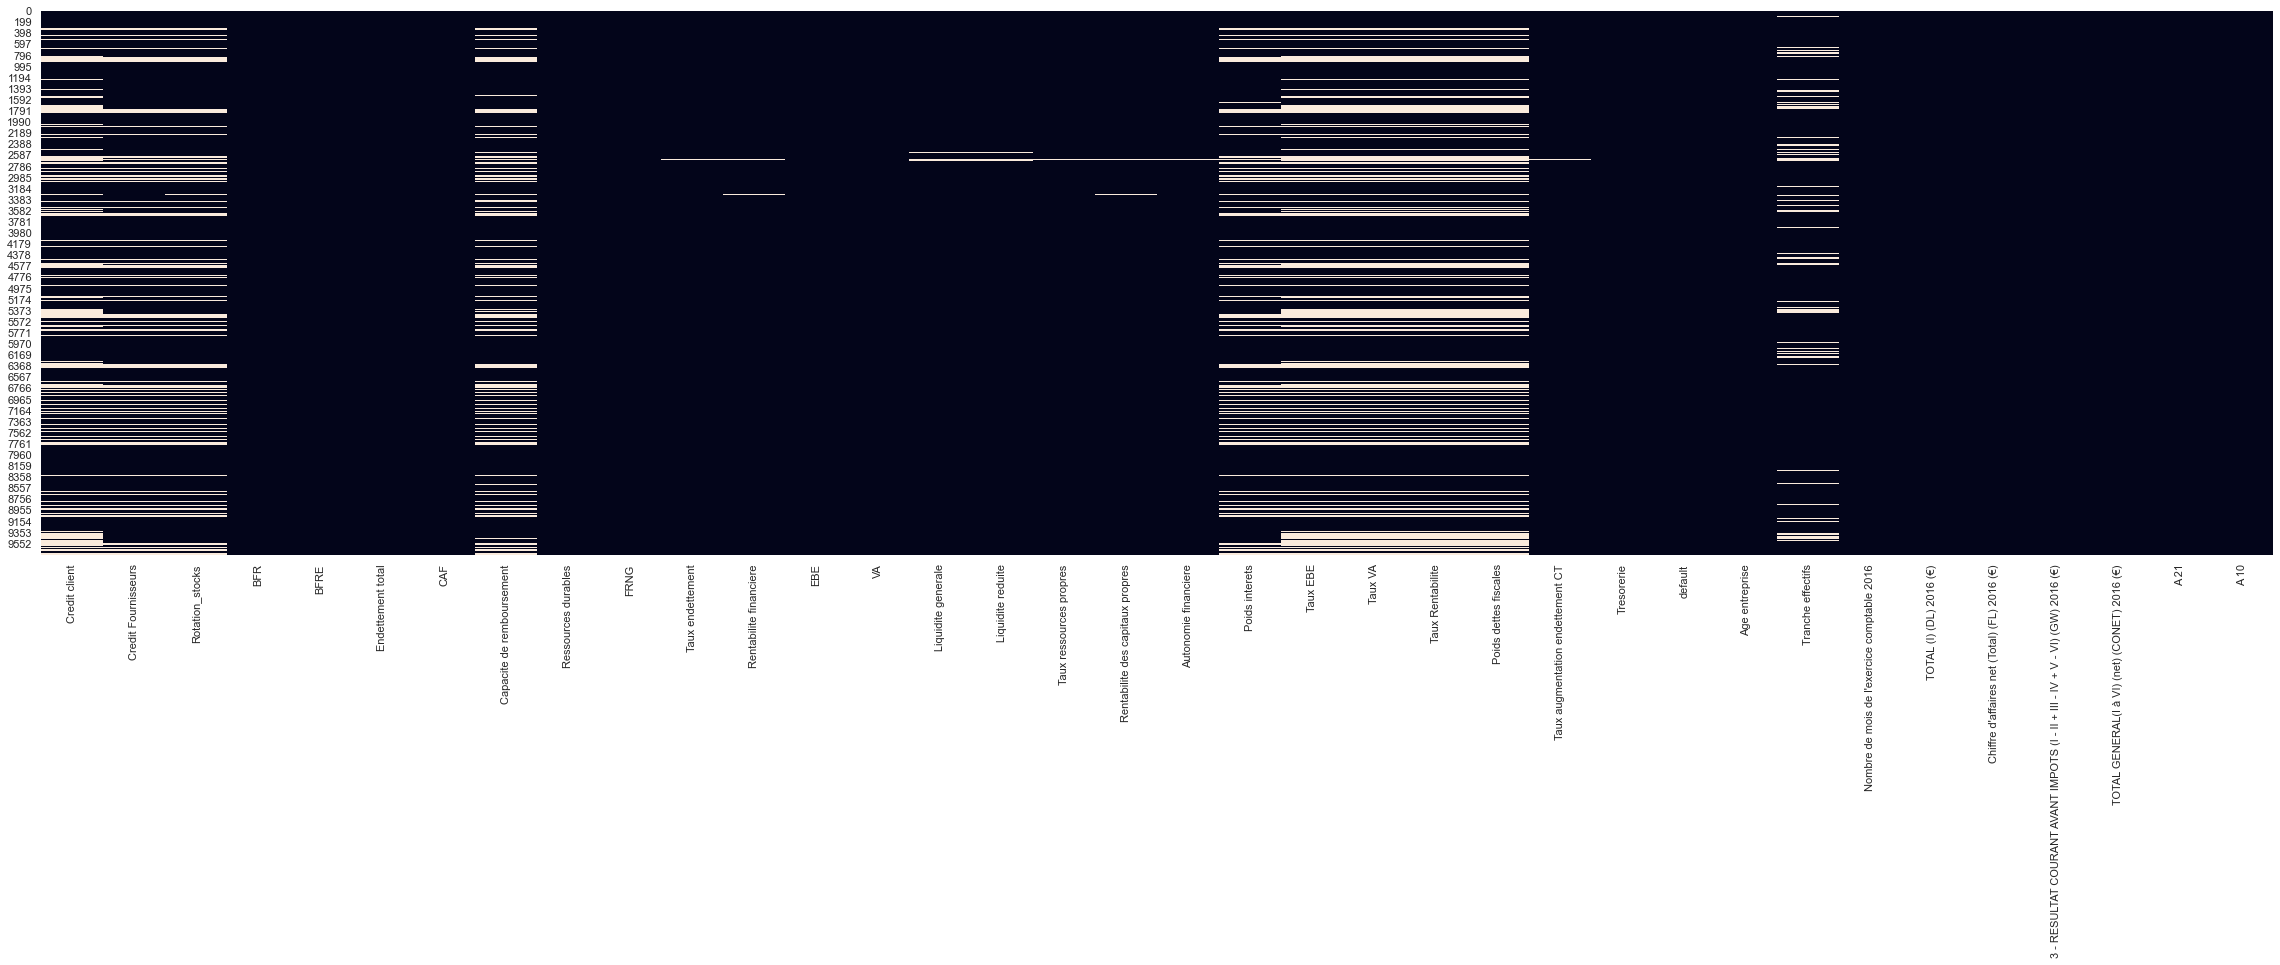

In [42]:
# heatmap des valeurs manquantes (en blanc)
plt.figure(figsize=(40,10))
sns.heatmap(eda.isna(), cbar=False)

In [43]:
eda2 = eda[eda["Chiffre d'affaires net (Total) (FL) 2016 (€)"] != 0]

In [44]:
eda2.shape

(7448, 36)

<AxesSubplot:>

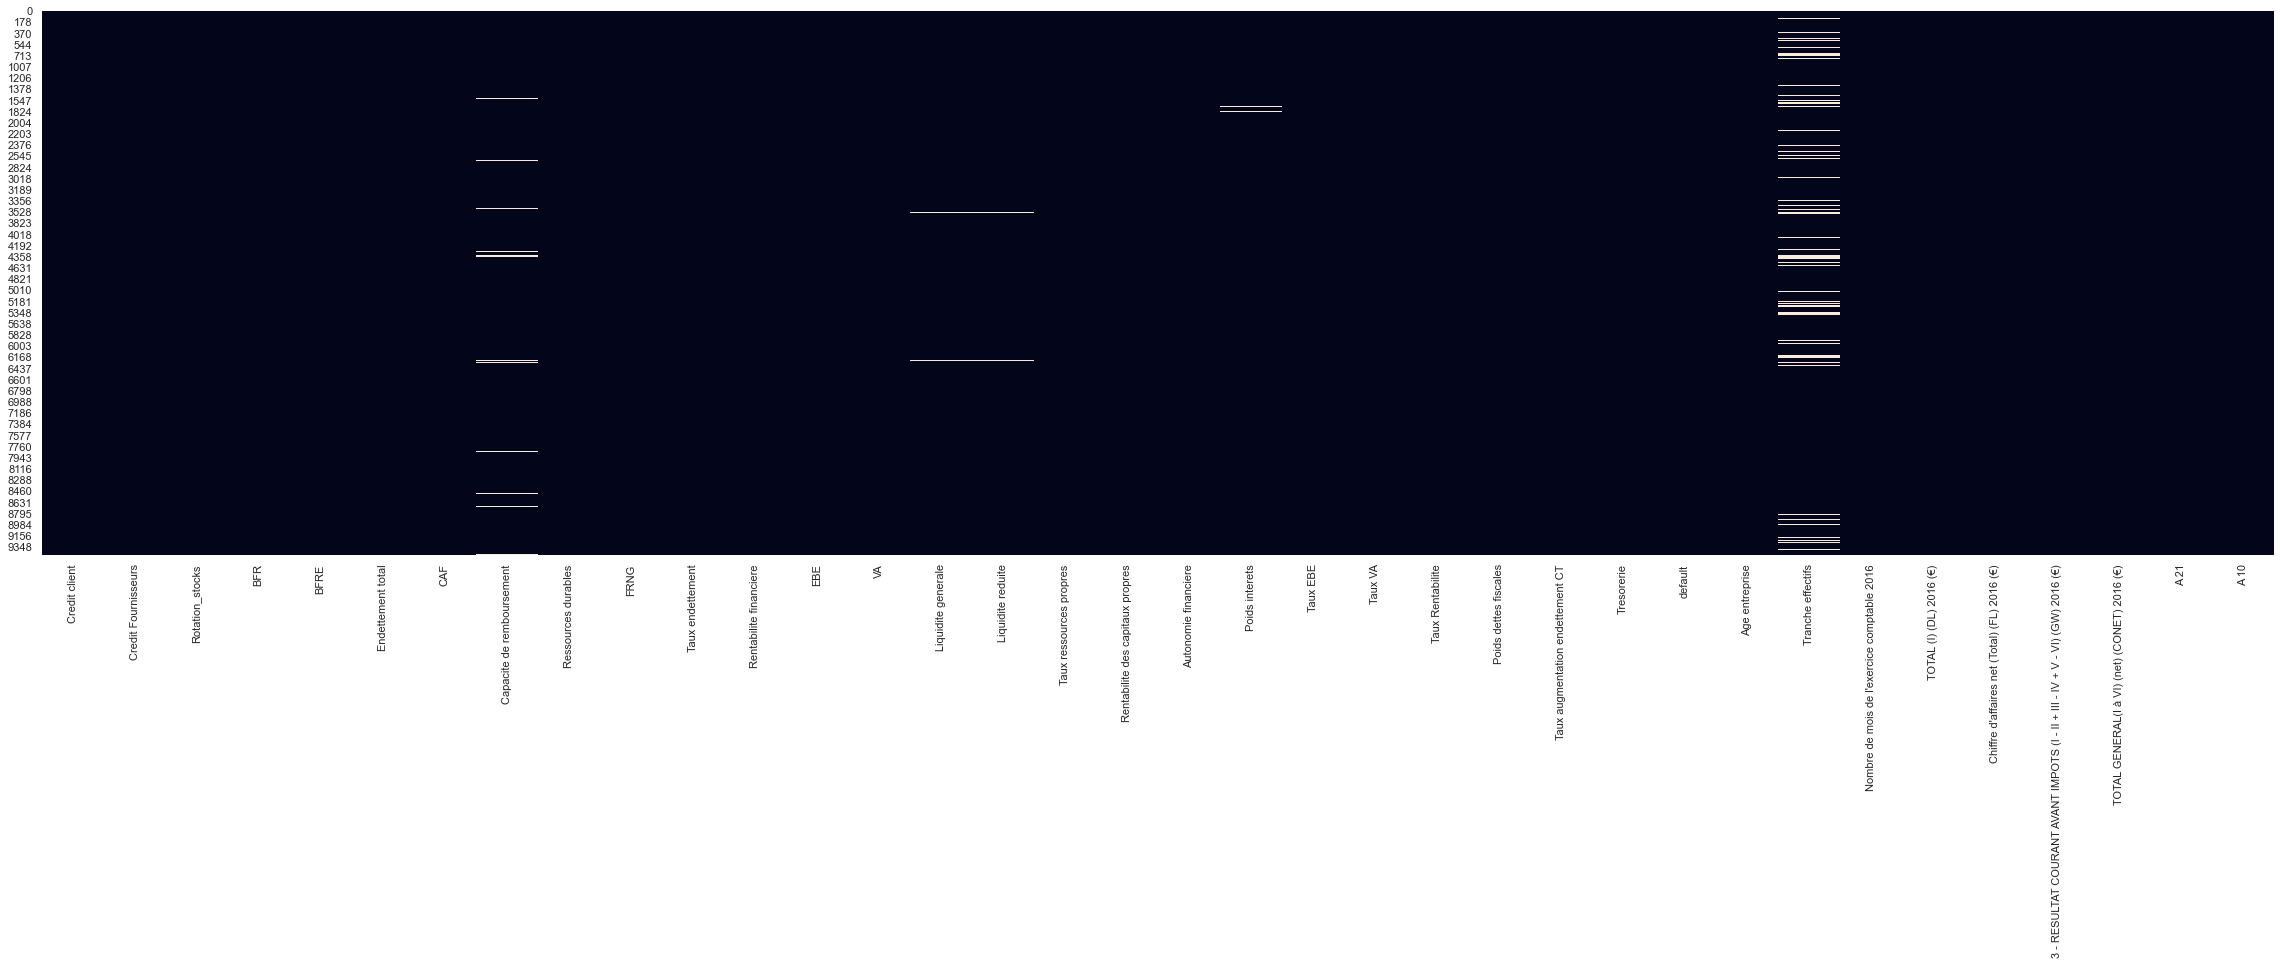

In [45]:
# heatmap des valeurs manquantes (en blanc) une fois les lignes avec CA null supprimées
plt.figure(figsize=(40,10))
sns.heatmap(eda2.isna(), cbar=False)

In [46]:
# total de NaN sur le dataset
eda.isna().sum().sum()/(eda.shape[0]*eda.shape[1])*100

5.5547008547008545

In [47]:
# taux de NaN par colonne
(eda.isna().sum()/eda.shape[0]).sort_values(ascending=False)

Credit client                                                                  0.23610
Poids dettes fiscales                                                          0.23610
Taux Rentabilite                                                               0.23610
Taux VA                                                                        0.23610
Taux EBE                                                                       0.23610
Capacite de remboursement                                                      0.18421
Poids interets                                                                 0.16277
Credit Fournisseurs                                                            0.16144
Rotation_stocks                                                                0.16092
Tranche effectifs                                                              0.12718
Liquidite generale                                                             0.00810
Liquidite reduite                          

In [48]:
# total de NaN sur le dataset
eda2.isna().sum().sum()/(eda2.shape[0]*eda.shape[1])*100

0.36400525122329636

In [49]:
# taux de NaN par colonne
(eda2.isna().sum()/eda2.shape[0]).sort_values(ascending=False)

Tranche effectifs                                                              0.10043
Capacite de remboursement                                                      0.01853
Liquidite reduite                                                              0.00363
Liquidite generale                                                             0.00363
Poids interets                                                                 0.00242
Credit Fournisseurs                                                            0.00107
Rentabilite financiere                                                         0.00040
Rentabilite des capitaux propres                                               0.00040
Taux endettement                                                               0.00013
Taux ressources propres                                                        0.00013
Autonomie financiere                                                           0.00013
Taux augmentation endettement CT           

### Heatmap corrélations

<AxesSubplot:>

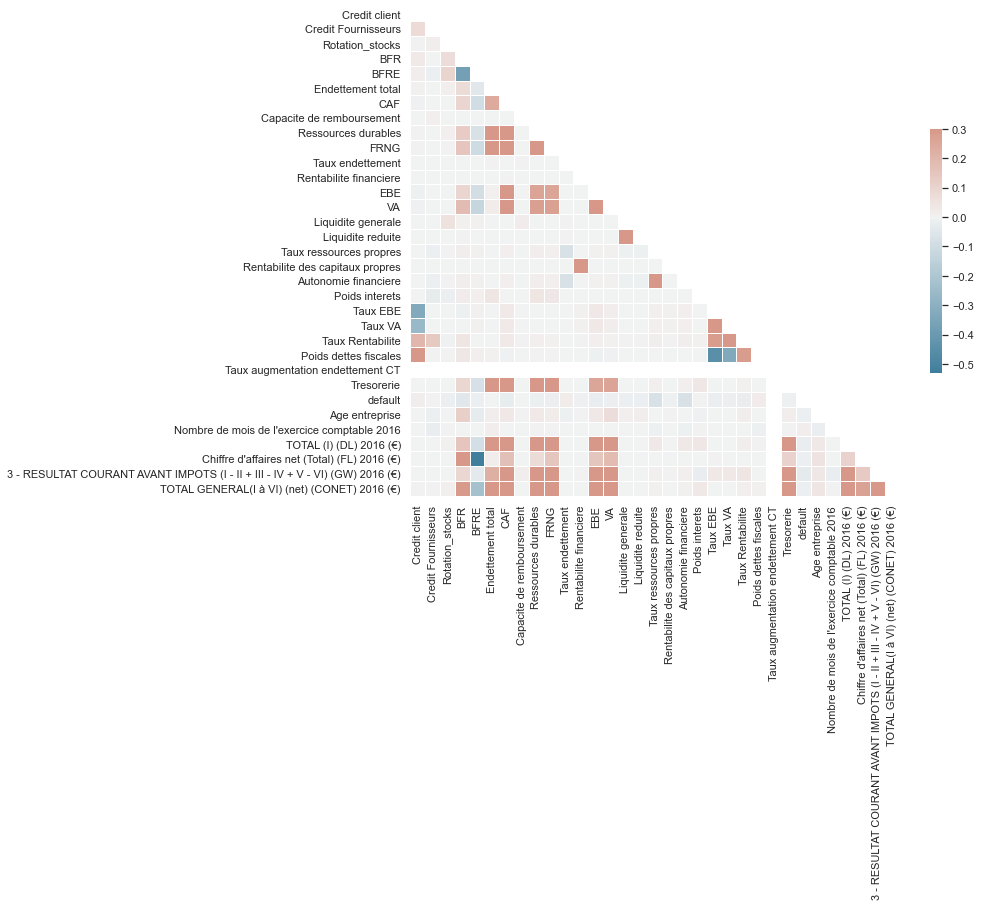

In [50]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")


# Compute the correlation matrix
corr = eda2.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### Focus sur les 2 variables les plus corrélées avec la target
- Taux ressources propres
- Autonomie financière

In [51]:
corr['default'].sort_values()

Taux ressources propres                                                        -0.07787
Autonomie financiere                                                           -0.07763
BFR                                                                            -0.04930
3 - RESULTAT COURANT AVANT IMPOTS (I - II + III - IV + V - VI) (GW) 2016 (€)   -0.03482
CAF                                                                            -0.02562
Taux Rentabilite                                                               -0.02411
TOTAL (I) (DL) 2016 (€)                                                        -0.02255
EBE                                                                            -0.02254
Taux EBE                                                                       -0.01936
Liquidite generale                                                             -0.01734
Taux VA                                                                        -0.01716
BFRE                            

In [52]:
eda4 = eda2[eda2['Taux ressources propres'] > -50]
eda4 = eda4[eda4['Taux ressources propres'] < 50]



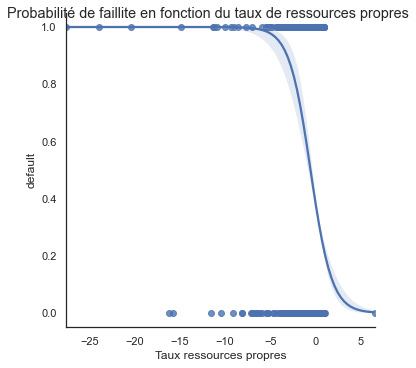

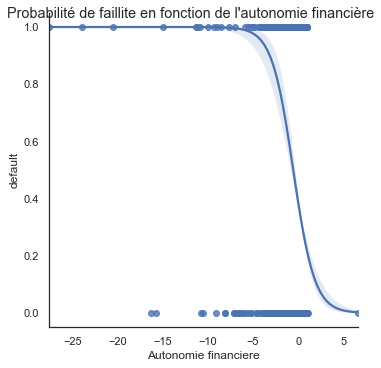

In [53]:
#df['age'].fillna(df['age'].median(skipna = True), inplace = True)

sns.lmplot(data=eda4, x='Taux ressources propres', y ='default', logistic=True).fig.suptitle('Probabilité de faillite en fonction du taux de ressources propres')
plt.show()
sns.lmplot(data=eda4, x='Autonomie financiere', y ='default', logistic=True).fig.suptitle('Probabilité de faillite en fonction de l\'autonomie financière')
plt.show()

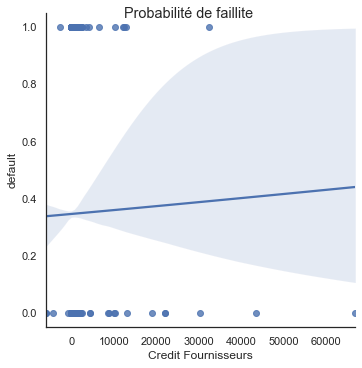

In [54]:
sns.lmplot(data=eda2, x='Credit Fournisseurs', y ='default', logistic=True).fig.suptitle('Probabilité de faillite')
plt.show()

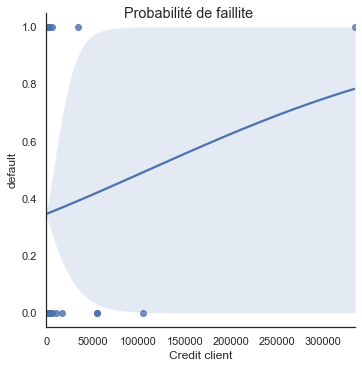

In [55]:
sns.lmplot(data=eda2, x='Credit client', y ='default', logistic=True).fig.suptitle('Probabilité de faillite')
plt.show()

In [56]:
eda_temp = eda2.copy()
eda_temp = eda_temp.rename(columns={'Taux ressources propres':'RP', 'Autonomie financiere':'AutoFi'})

In [57]:
eda_temp.columns

Index(['Credit client', 'Credit Fournisseurs', 'Rotation_stocks', 'BFR', 'BFRE', 'Endettement total', 'CAF', 'Capacite de remboursement', 'Ressources durables', 'FRNG', 'Taux endettement', 'Rentabilite financiere', 'EBE', 'VA', 'Liquidite generale', 'Liquidite reduite', 'RP', 'Rentabilite des capitaux propres', 'AutoFi', 'Poids interets', 'Taux EBE', 'Taux VA', 'Taux Rentabilite', 'Poids dettes fiscales', 'Taux augmentation endettement CT', 'Tresorerie', 'default', 'Age entreprise', 'Tranche effectifs', 'Nombre de mois de l'exercice comptable 2016', 'TOTAL (I) (DL) 2016 (€)', 'Chiffre d'affaires net (Total) (FL) 2016 (€)', '3 - RESULTAT COURANT AVANT IMPOTS (I - II + III - IV + V - VI) (GW) 2016 (€)', 'TOTAL GENERAL(I à VI) (net) (CONET) 2016 (€)', 'A 21', 'A 10'], dtype='object')

In [58]:
# building the model and fitting the data
import statsmodels.api as sm
import statsmodels.formula.api as smf
f = 'default ~ RP + AutoFi'
logitfit = smf.logit(formula = str(f), data = eda_temp).fit()

# Inspecte les résultats 
logitfit.summary()

Optimization terminated successfully.
         Current function value: 0.625739
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                 7447
Model:                          Logit   Df Residuals:                     7444
Method:                           MLE   Df Model:                            2
Date:                Fri, 02 Sep 2022   Pseudo R-squ.:                 0.03006
Time:                        16:36:10   Log-Likelihood:                -4659.9
converged:                       True   LL-Null:                       -4804.3
Covariance Type:            nonrobust   LLR p-value:                 1.867e-63
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4987      0.027    -18.296      0.000      -0.552      -0.445
RP            -3.4175      1.725     -1.981      0.048      -6.798      -0.037
AutoFi         2.7550      1.726      1.596      0.110      -0.628       6.138
==============================================================================
"""

In [59]:
# building the model and fitting the data
f_2 = 'default ~ AutoFi'
logitfit = smf.logit(formula = str(f_2), data = eda_temp).fit()

# Inspecte les résultats 
logitfit.summary()

Optimization terminated successfully.
         Current function value: 0.626115
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                 7447
Model:                          Logit   Df Residuals:                     7445
Method:                           MLE   Df Model:                            1
Date:                Fri, 02 Sep 2022   Pseudo R-squ.:                 0.02948
Time:                        16:36:10   Log-Likelihood:                -4662.7
converged:                       True   LL-Null:                       -4804.3
Covariance Type:            nonrobust   LLR p-value:                 1.450e-63
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4946      0.027    -18.192      0.000      -0.548      -0.441
AutoFi        -0.6638      0.048    -13.810      0.000      -0.758      -0.570
==============================================================================
"""

In [60]:
# building the model and fitting the data
f_3 = 'default ~ RP'
logitfit = smf.logit(formula = str(f_3), data = eda_temp).fit()

# Inspecte les résultats 
logitfit.summary()

Optimization terminated successfully.
         Current function value: 0.625968
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                 7447
Model:                          Logit   Df Residuals:                     7445
Method:                           MLE   Df Model:                            1
Date:                Fri, 02 Sep 2022   Pseudo R-squ.:                 0.02971
Time:                        16:36:10   Log-Likelihood:                -4661.6
converged:                       True   LL-Null:                       -4804.3
Covariance Type:            nonrobust   LLR p-value:                 4.814e-64
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4947      0.027    -18.206      0.000      -0.548      -0.441
RP            -0.6668      0.048    -13.866      0.000      -0.761      -0.573
==============================================================================
"""

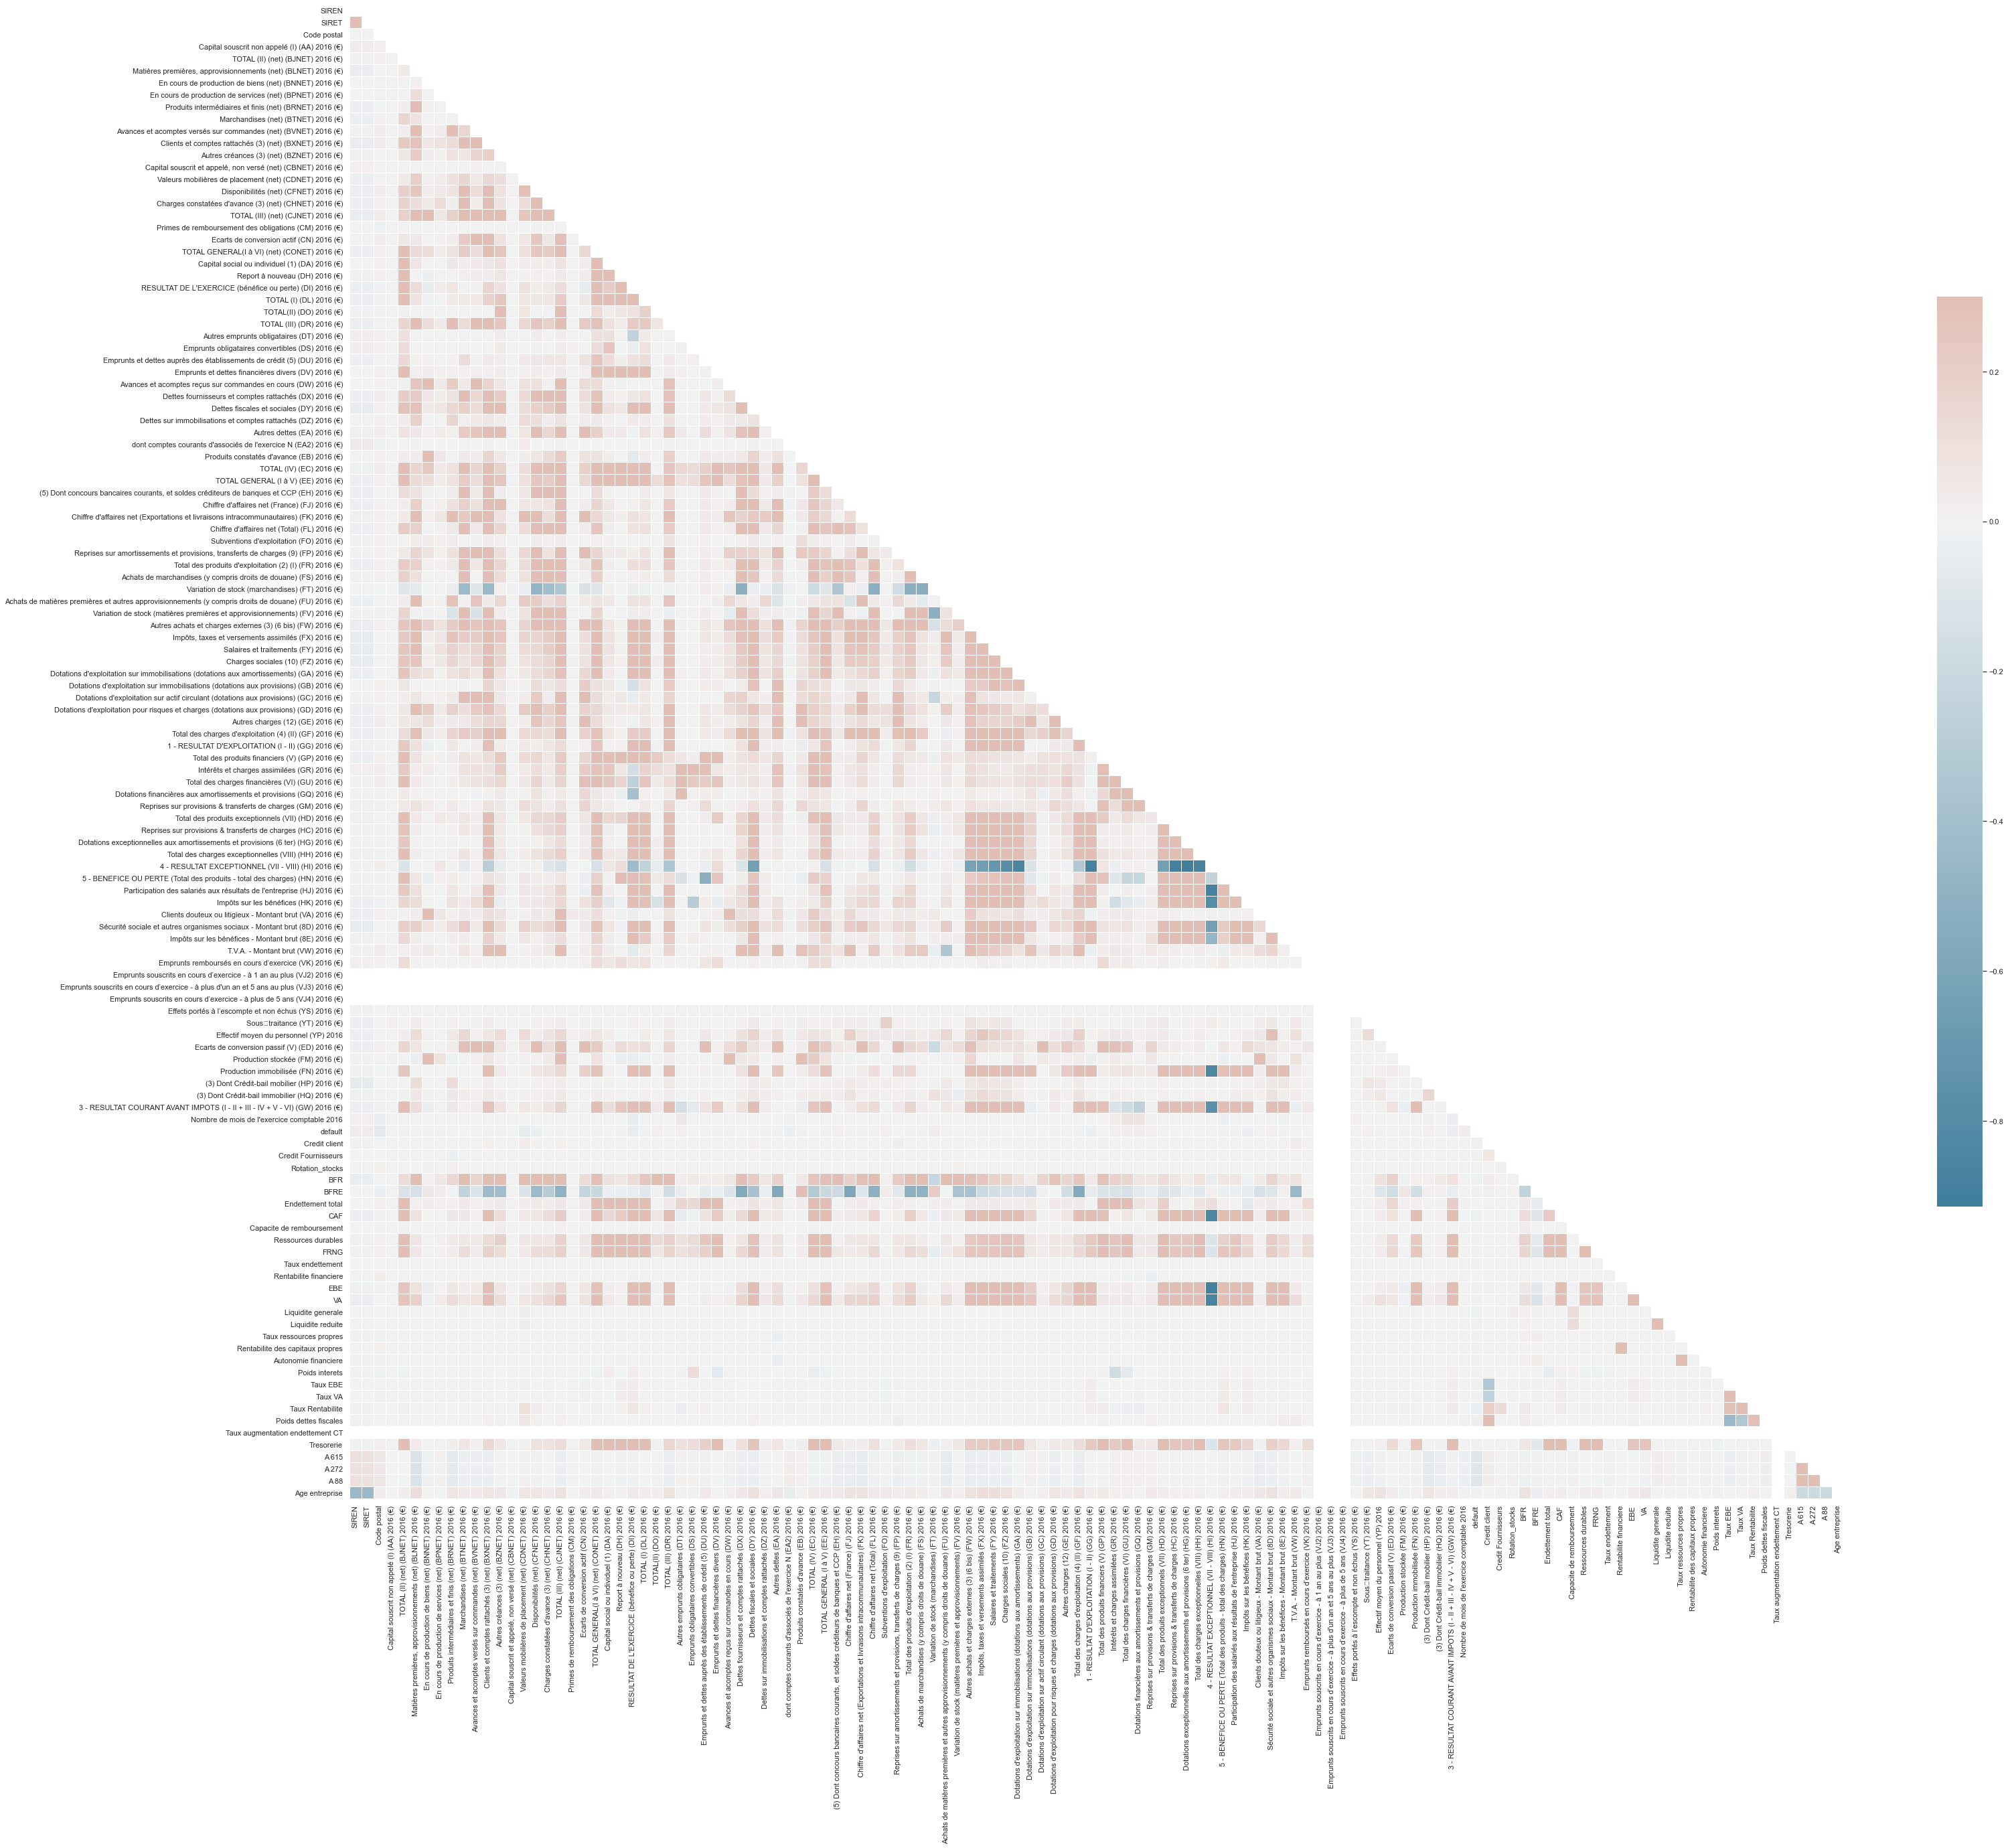

In [72]:
# Compute the correlation matrix
corr2 = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr2, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(50, 50))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr2, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.savefig("correlation_2016.jpg")

### Analyse des distributions selon la target

#### Première approche : scatterplot des features contre elle-même, hue sur la target

<ipython-input-62-8ce272496ac1>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ((axe1,axe2,axe3)) = plt.subplots(nrows=1,ncols=3, figsize = (20,5))


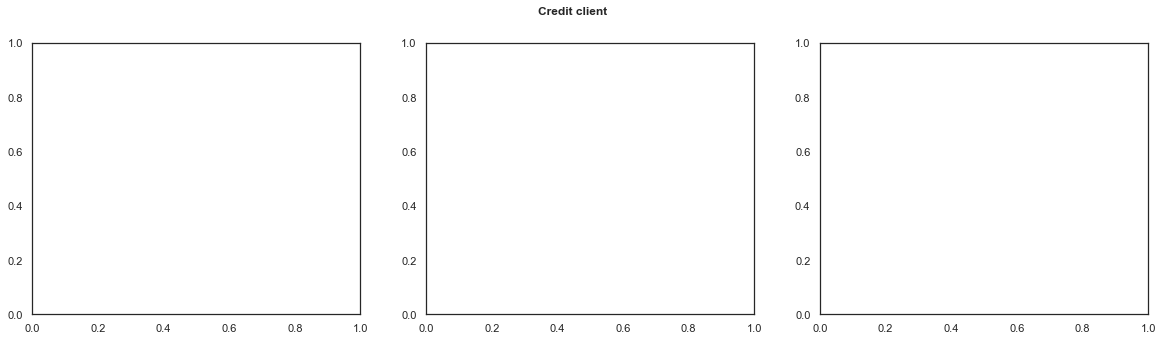

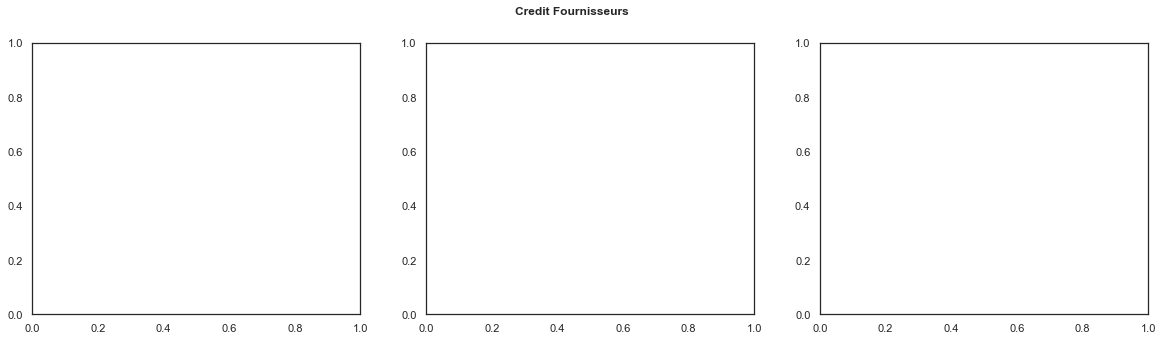

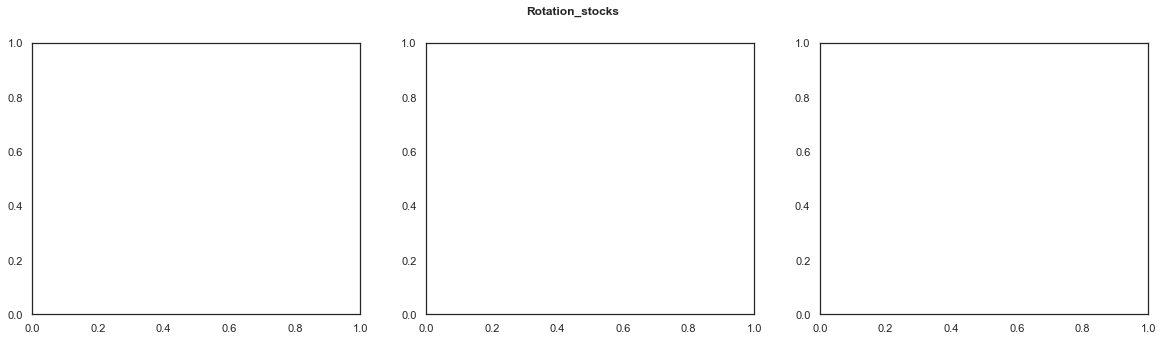

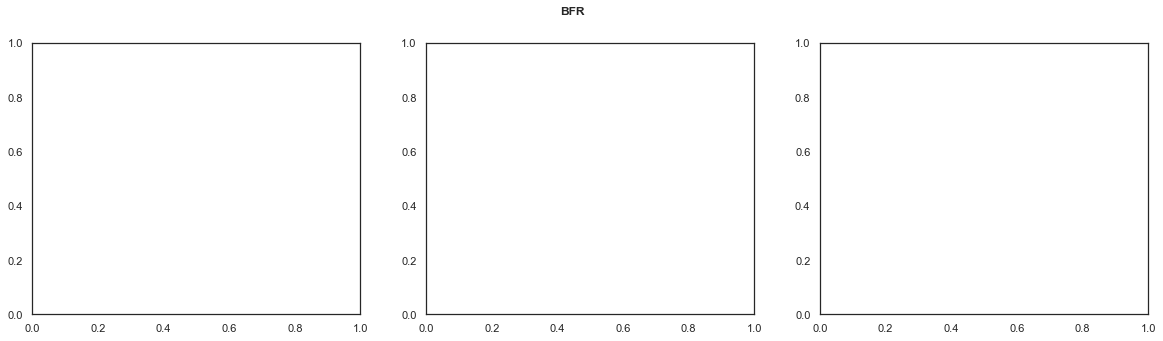

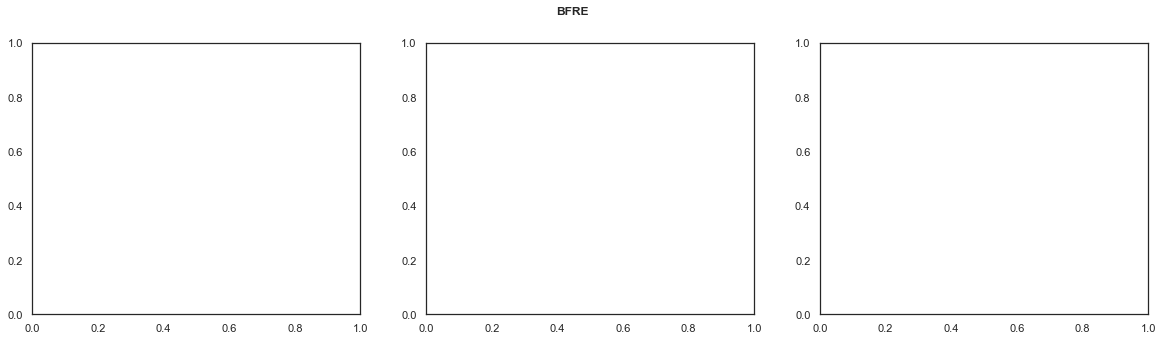

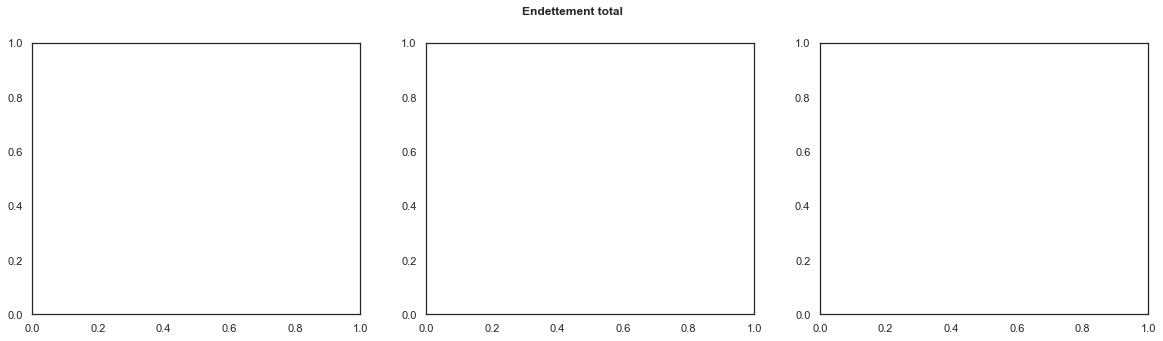

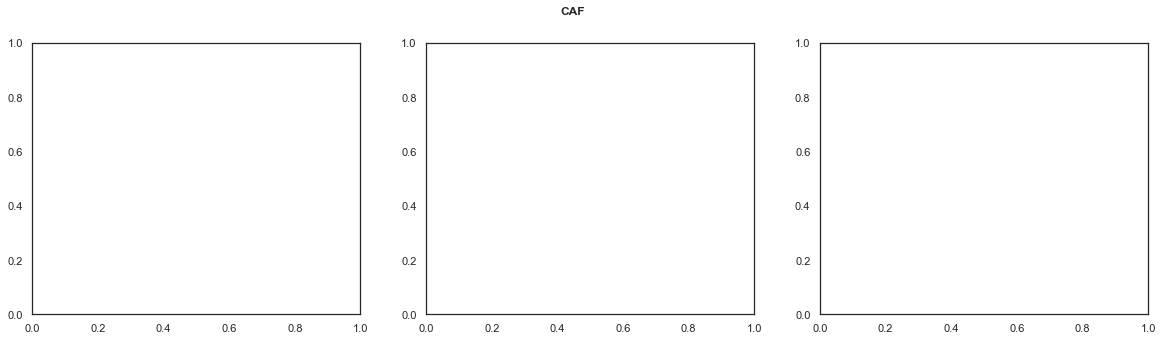

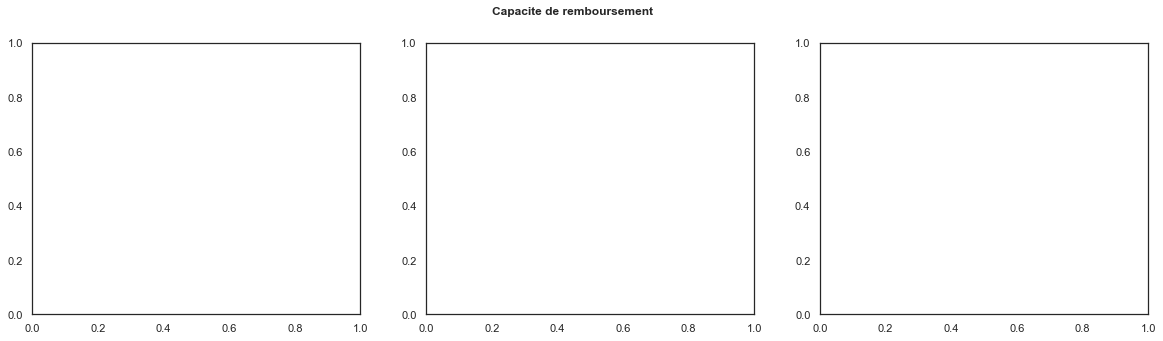

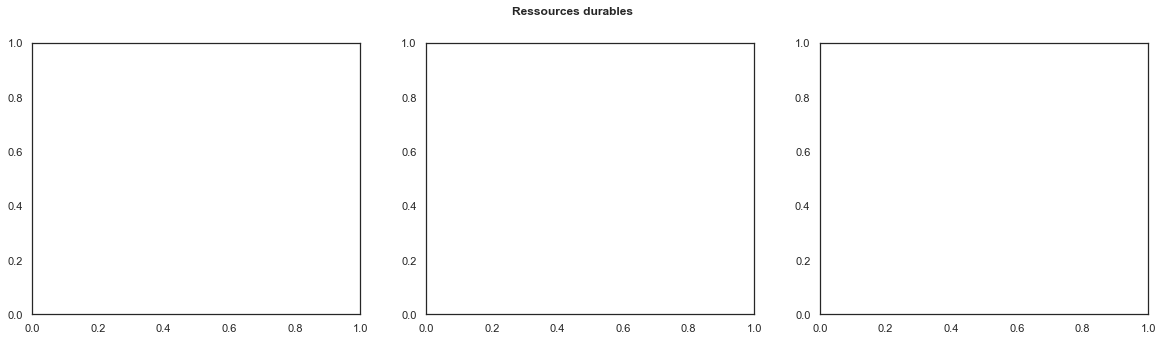

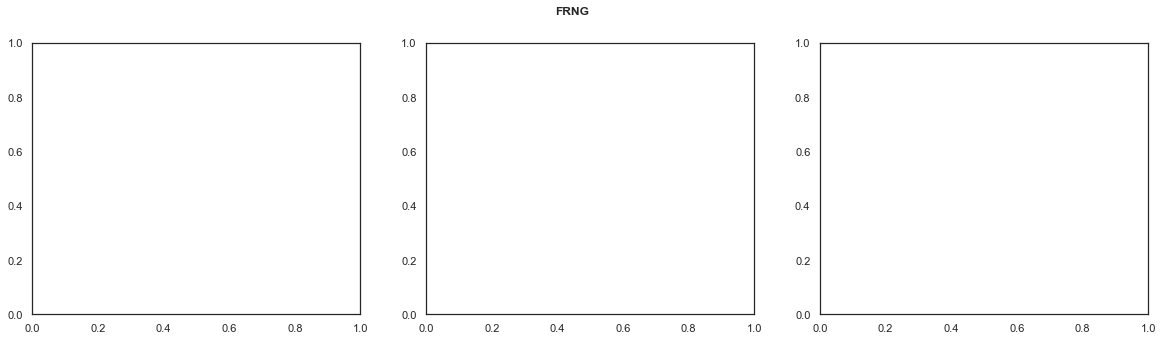

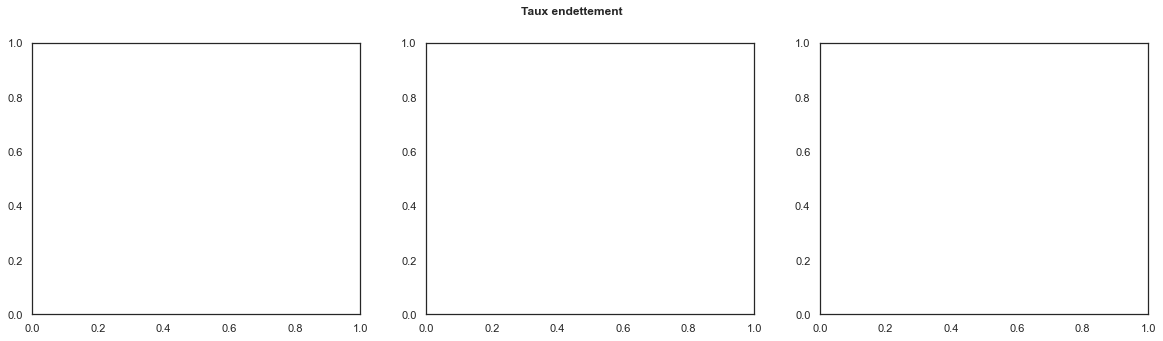

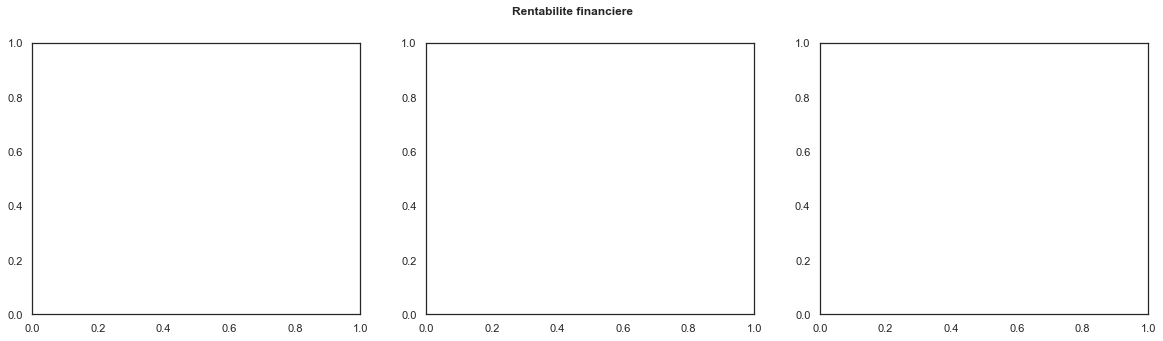

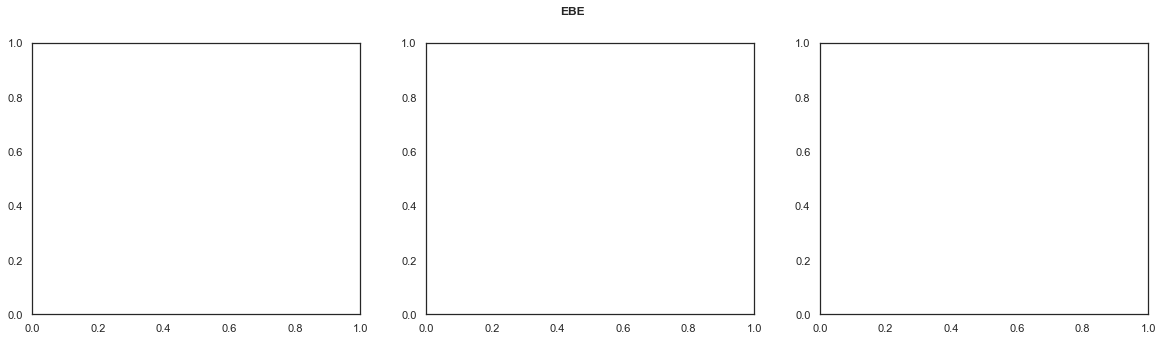

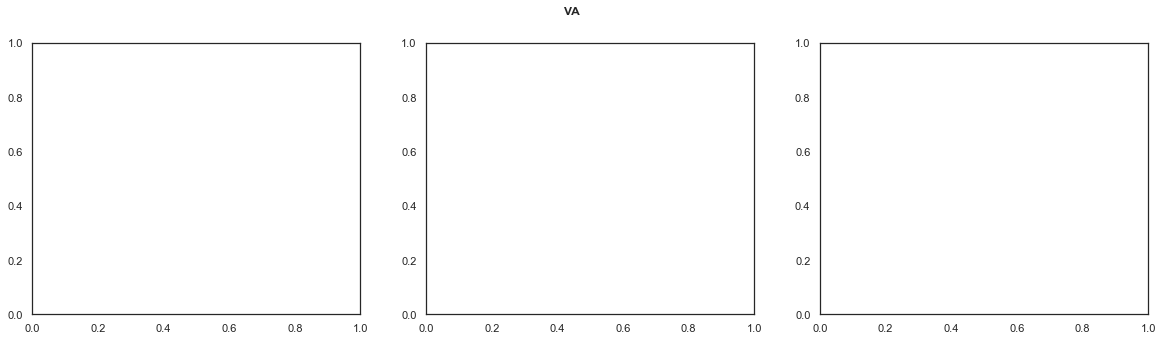

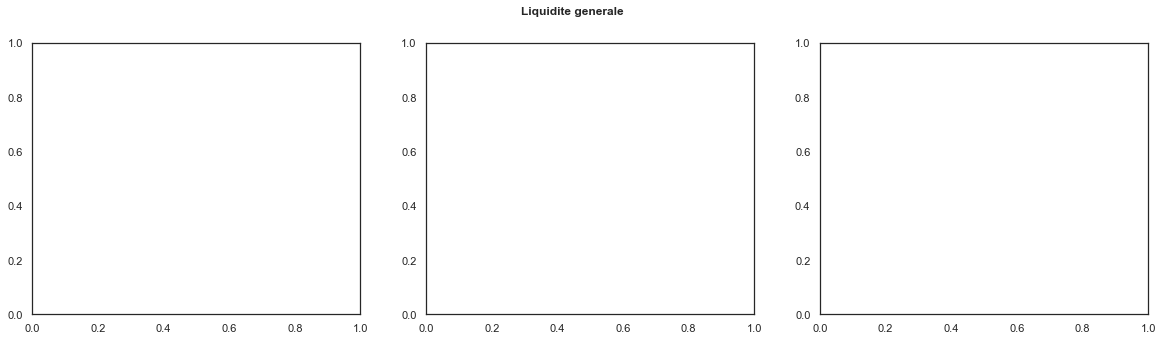

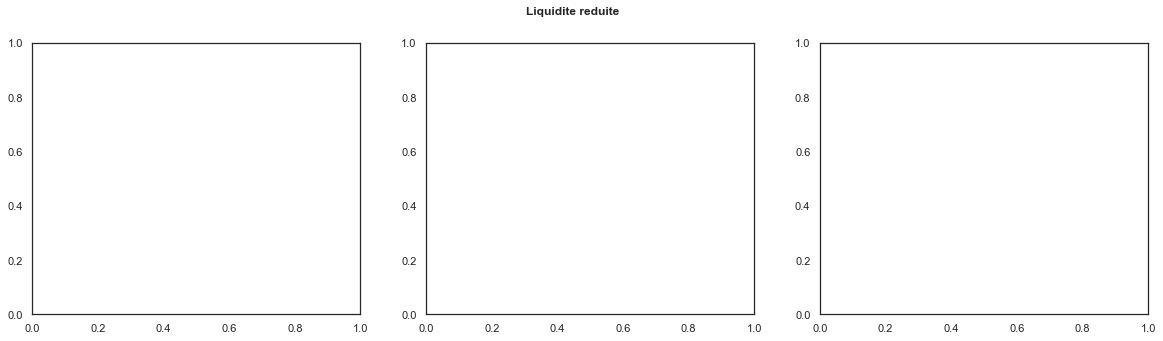

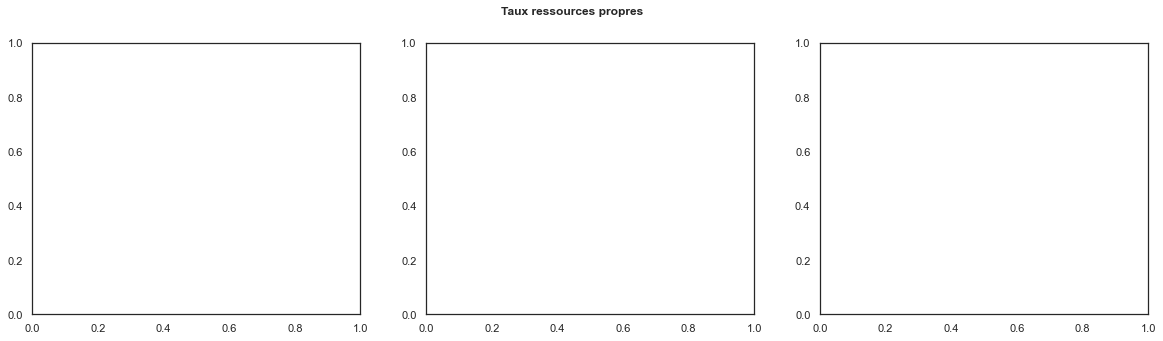

Error in callback <function flush_figures at 0x11fe46940> (for post_execute):


KeyboardInterrupt: 

In [62]:
for col in eda2.select_dtypes('number'):
    fig, ((axe1,axe2,axe3)) = plt.subplots(nrows=1,ncols=3, figsize = (20,5))
    fig.suptitle(f'{col}', fontsize=12,fontweight="bold")

In [ ]:
# qq plot
from scipy import stats
import seaborn as sns
for col in eda2.select_dtypes('number'):
    plt.figure()
    stats.probplot(df[col], plot=sns.mpl.pyplot)

In [ ]:
# Histogramme des variables continues

for col in eda2.select_dtypes('number'):
    plt.figure()
    sns.scatterplot(x=eda2[col], y=eda2[col], hue=eda2['default'])
    plt.show()
    plt.ion()


#### Deuxième approche : histogrammes différenciés

In [63]:
eda2_default = eda2[eda2["default"] == 1]
eda2_saines = eda2[eda2["default"] == 0]
print(eda2.shape, eda2_default.shape, eda2_saines.shape)

(7448, 36) (2579, 36) (4869, 36)


/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


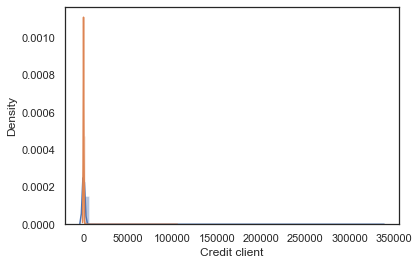

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


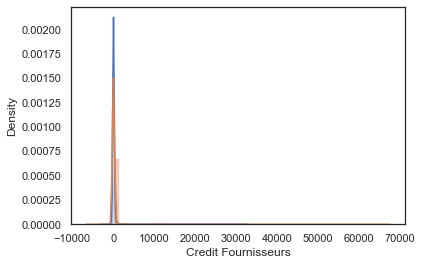

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


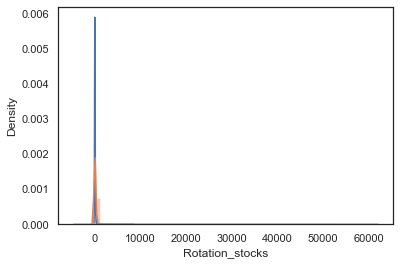

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


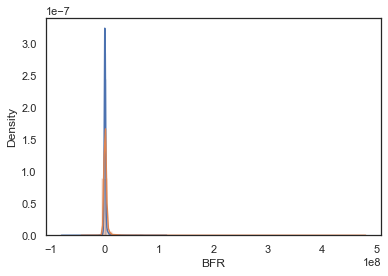

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


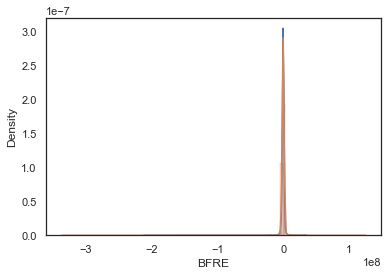

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


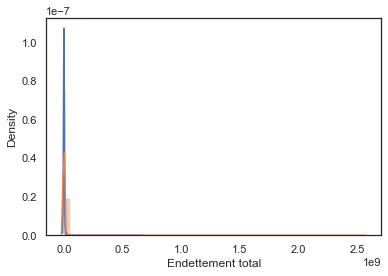

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


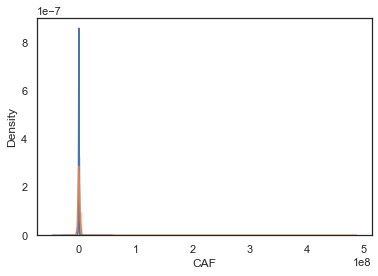

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


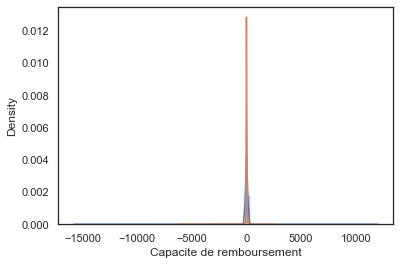

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


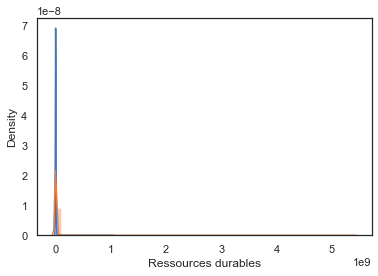

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


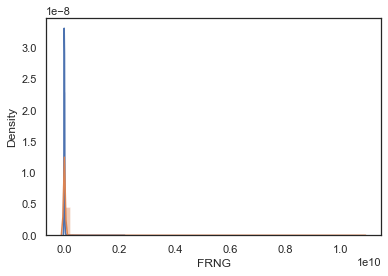

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


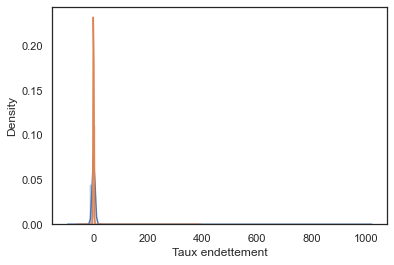

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


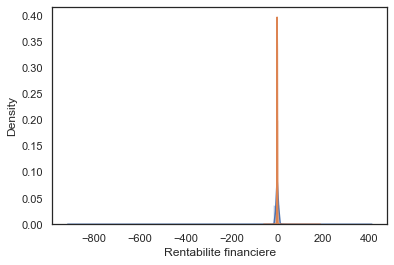

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


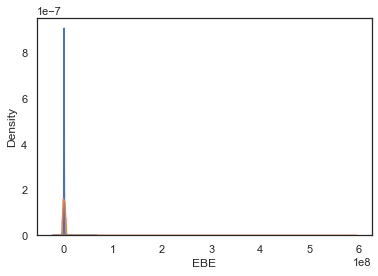

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


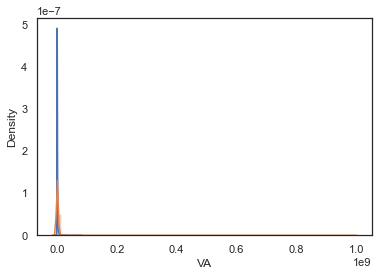

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


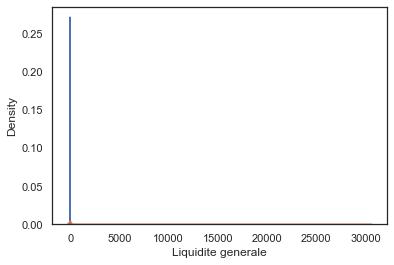

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


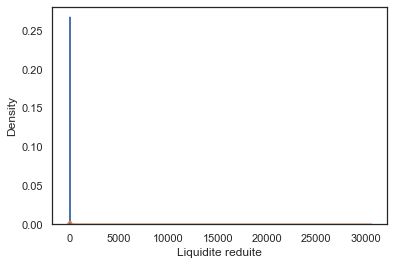

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


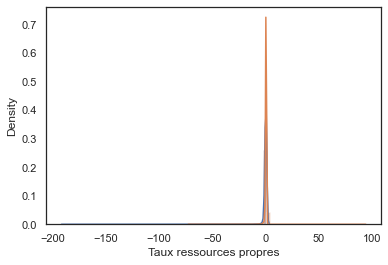

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


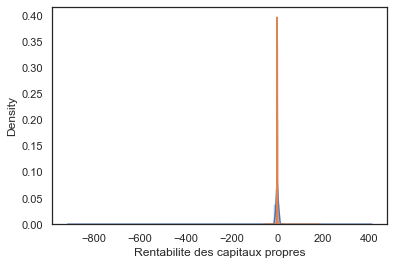

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


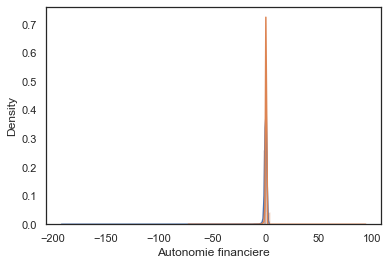

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


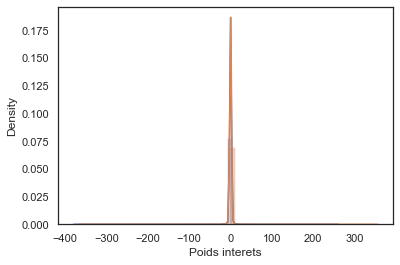

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


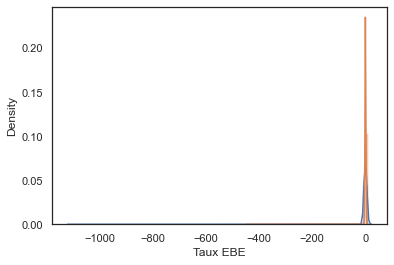

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


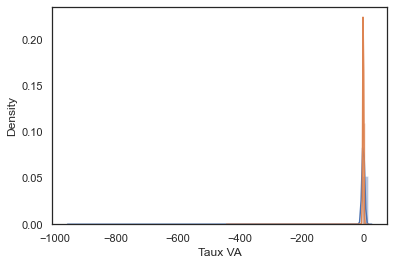

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


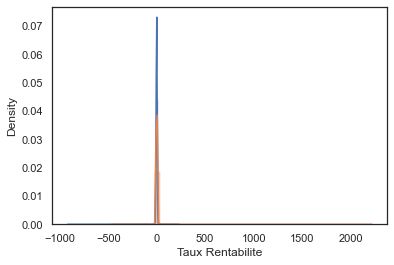

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


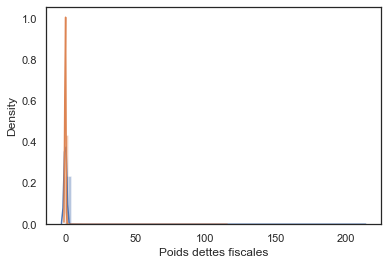

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/

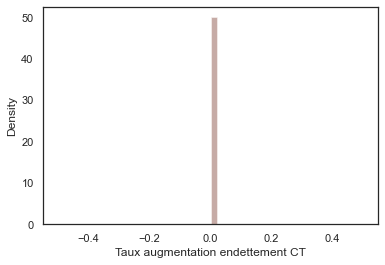

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


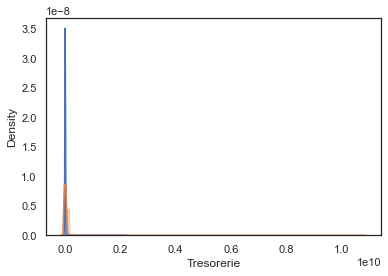

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/

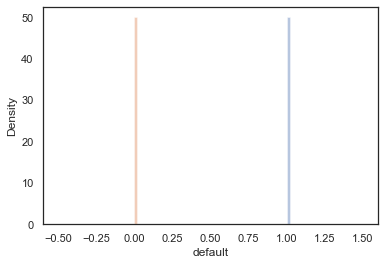

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


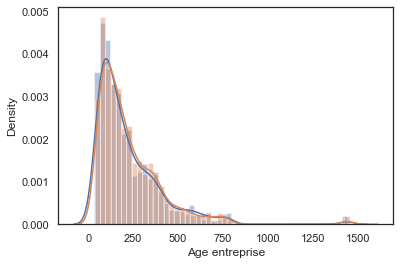

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


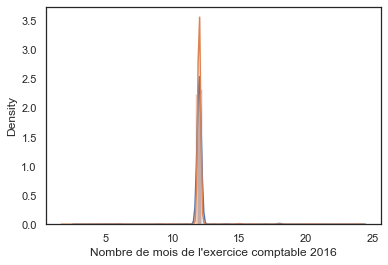

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


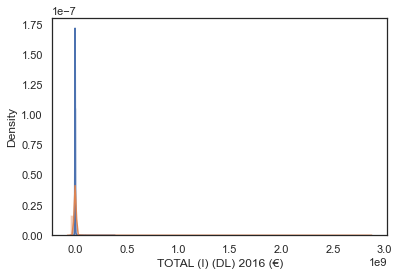

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


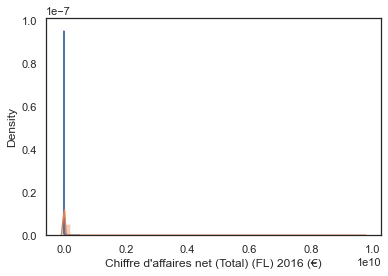

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


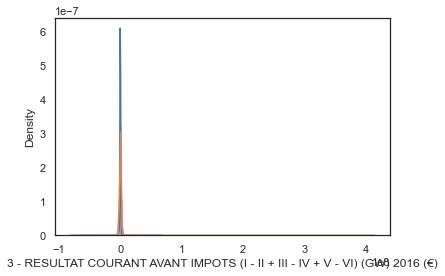

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


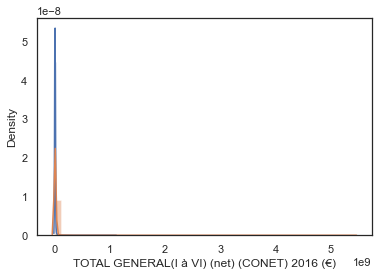

In [64]:
for col in eda2.select_dtypes(np.number):
    plt.figure()
    sns.distplot(eda2_default[col], label='défaillantes')
    sns.distplot(eda2_saines[col], label='saines')
    plt.show()
    plt.ion()

In [ ]:
# Histogramme des variables continues
from scipy import stats

for col in eda2.select_dtypes('number'):
    plt.figure()
    sns.boxplot(eda2[col])
    plt.show()
    

## Supprimer les outliers ?
### De façon non discriminée

In [ ]:
''' Detection '''
# IQR
Q1 = np.percentile(df_boston['DIS'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(df_boston['DIS'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1
 
print("Old Shape: ", df_boston.shape)
 
# Upper bound
upper = np.where(df_boston['DIS'] >= (Q3+1.5*IQR))
# Lower bound
lower = np.where(df_boston['DIS'] <= (Q1-1.5*IQR))
 
''' Removing the Outliers '''
df_boston.drop(upper[0], inplace = True)
df_boston.drop(lower[0], inplace = True)
 
print("New Shape: ", df_boston.shape)

In [ ]:
# IQR
def remove_outliers(df):
    for col in df.select_dtypes(np.number):
        print("Start shape : ", df.shape)
        Q1 = np.percentile(df[col], 25,
                           interpolation = 'midpoint')
        Q3 = np.percentile(df[col], 75,
                           interpolation = 'midpoint')
        IQR = Q3 - Q1
        # Upper bound
        upper = np.where(df[col] >= (Q3+1.5*IQR))
        # Lower bound
        lower = np.where(df[col] <= (Q1-1.5*IQR))
        # Removing outliers
        df = df.drop(index=upper[0])
        #df = df.drop(index=lower[0])
        print("End shape : ", df.shape)
    return df

In [ ]:
# (modified from http://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm)
def get_iqr_values(df_in, col_name):
    median = df_in[col_name].median()
    q1 = df_in[col_name].quantile(0.25) # 25th percentile / 1st quartile
    q3 = df_in[col_name].quantile(0.75) # 7th percentile / 3rd quartile
    iqr = q3-q1 #Interquartile range
    minimum  = q1-1.5*iqr # The minimum value or the |- marker in the box plot
    maximum = q3+1.5*iqr # The maximum value or the -| marker in the box plot
    return median, q1, q3, iqr, minimum, maximum

def get_iqr_text(df_in, col_name):
    median, q1, q3, iqr, minimum, maximum = get_iqr_values(df_in, col_name)
    text = f"median={median:.2f}, q1={q1:.2f}, q3={q3:.2f}, iqr={iqr:.2f}, minimum={minimum:.2f}, maximum={maximum:.2f}"
    return text

def remove_outliers(df_in, col_name):
    _, _, _, _, minimum, maximum = get_iqr_values(df_in, col_name)
    df_out = df_in.loc[(df_in[col_name] > minimum) & (df_in[col_name] < maximum)]
    return df_out

def count_outliers(df_in, col_name):
    _, _, _, _, minimum, maximum = get_iqr_values(df_in, col_name)
    print("Montant minimum --> ", minimum)
    print("Nb minimum --> ", df_in.loc[(df_in[col_name] <= minimum)].shape[0])
    print("Montant maximum --> ",maximum)
    print("Nb maximum --> ", df_in.loc[(df_in[col_name] >= maximum)].shape[0])
    df_outliers = df_in.loc[(df_in[col_name] <= minimum) | (df_in[col_name] >= maximum)]
    return df_outliers.shape[0]

def box_and_whisker(df_in, col_name):
    title = get_iqr_text(df_in, col_name)
    sns.boxplot(df_in[col_name])
    plt.title(title)
    plt.show()

In [ ]:
for col in eda2.select_dtypes(np.number):
    print(f"{col} has {count_outliers(eda2, col)} outliers")

In [ ]:
for col in eda2.select_dtypes(np.number):
    eda2 = remove_outliers(eda2, col)
    print(eda2.shape[0])
    

## Je tente de tout passer en log 
Raisons : les distributions ne sont pas normales
Elles sont surtout fortement asymétriques vers les valeurs hautes. Donc je tente de réduire cette asymétrie avec de logs, car sinon j'ai des "outliers" au sens de l'Intervalle inter quartile qui, si je les supprime, me vident 100% de mes données
- Trouver une transformation permettant d'écraser les queues de distribution pour diminuer le nombre d'outliers, et 
- Vérifier ca avec le test rapide des modèles pour voir si ca change quelque chose sur les scores

**Premier essai : un passage de tout le dataset en log.**
- Une fois la transformation en log de faite, j'ai toujours des différences sur les qq plots mais les distplots semblent plus lisibles et ressemblent quand même plus à des lois normales.
- Quand je refais les calculs d'outliers, j'aboutis à peu de valeurs sur la tranche du haut.
- Problème : trop de valeurs nulles et négatives, non prises en charge par le log. Ainsi on a 100% du dataset "out" si on enlève les nan.On a plus de la moitié des colonnes qui dépassent les 16% de NaN.

**Deuxième essai : un passage de tout le dataset en racine carrée**
- Essai de passer en racine carrée. C'est mieux mais, ne prenant pas en charge les valeurs négatives, on a là encore beaucoup de colonnes affichant trop de NaN.

**Quelle solution ? Faut-il vraiment s'inquiéter des "outliers"**
Peut-etre autant de valeurs "extrêmes" car on n'est pas du tout dans le cadre d'une loi normale et qu'il ne faut pas chercher à y rentrer ?
Peut-être que mes données sont très mauvaises ?



### Premier essai : un passage de tout le dataset en log.

In [65]:
eda2_num = eda2.select_dtypes(np.number)

In [66]:
eda_log = np.log(eda2_num)

In [67]:
eda_log.shape

(7448, 33)

In [68]:
for col in eda_log.columns:
    print(f"{col} has {count_outliers(eda_log, col)} outliers")

NameError: name 'count_outliers' is not defined

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to

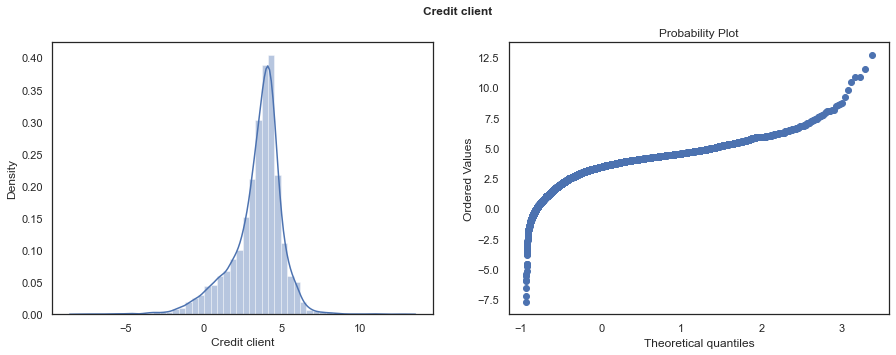

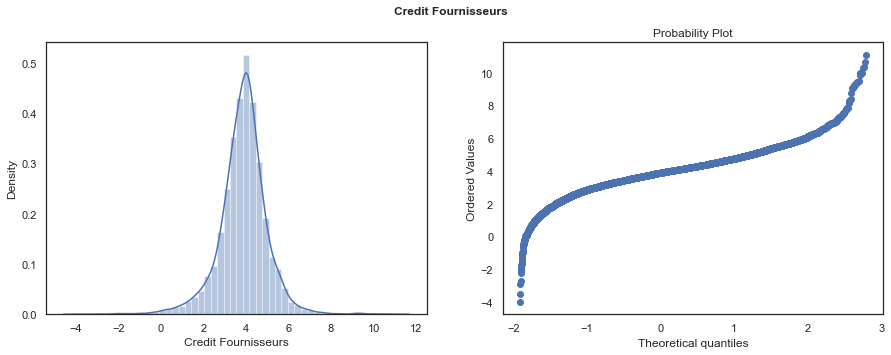

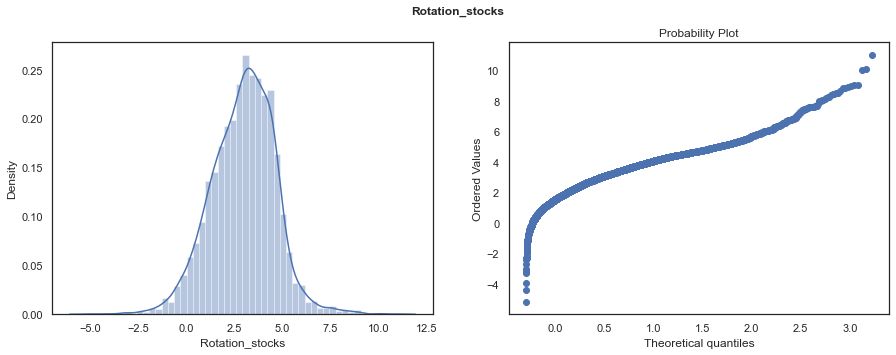

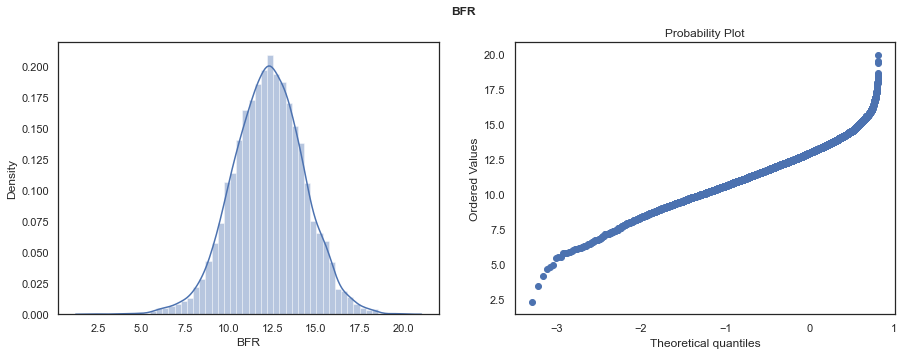

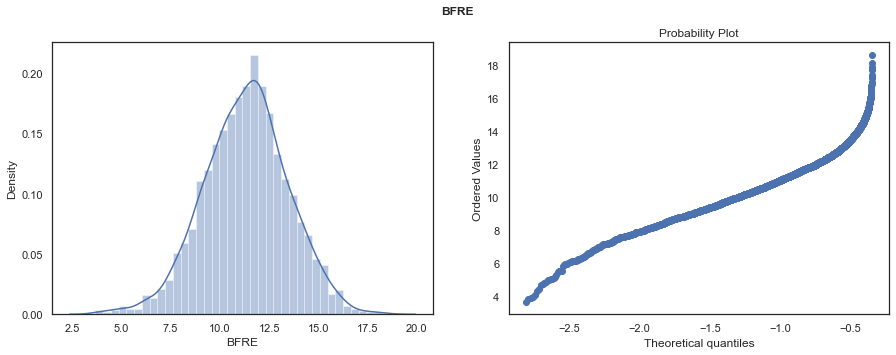

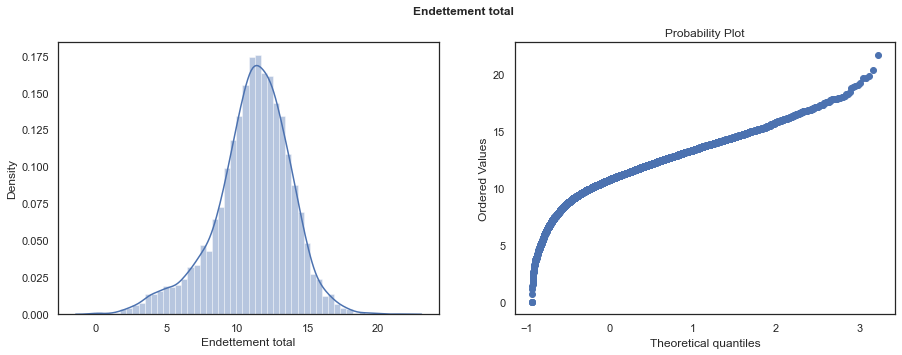

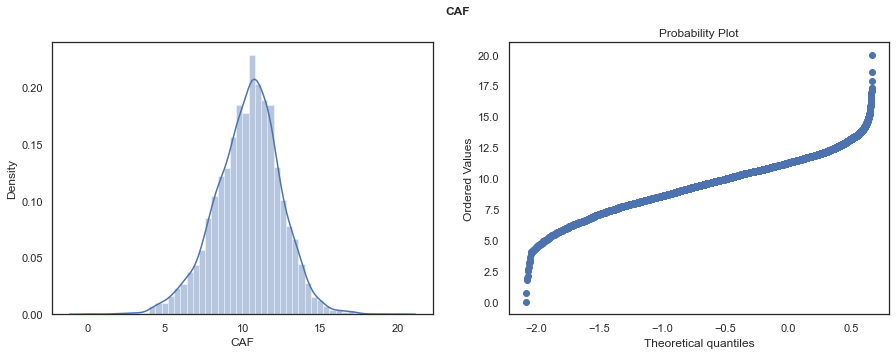

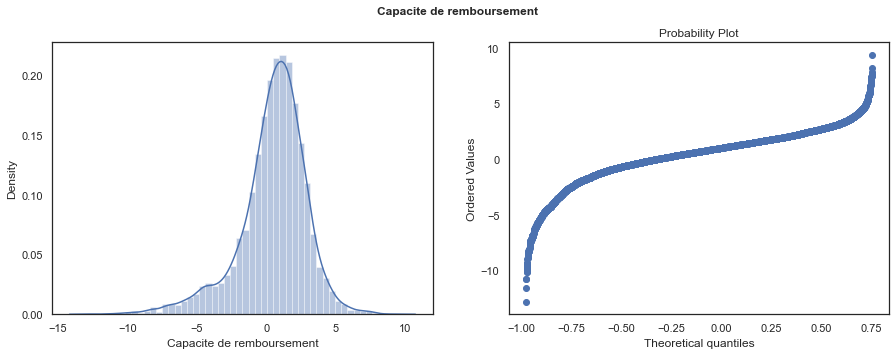

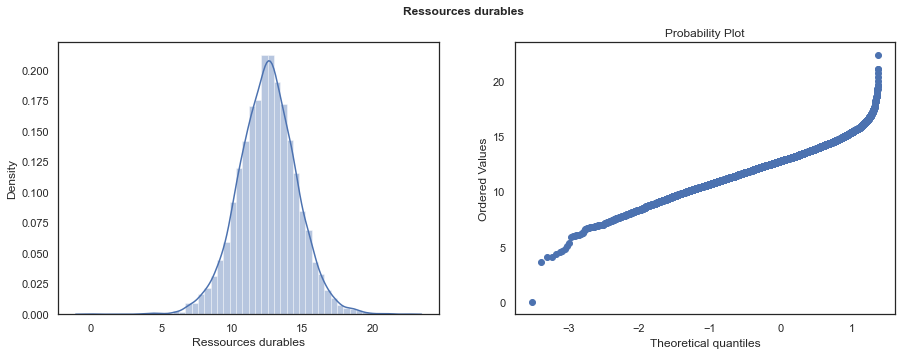

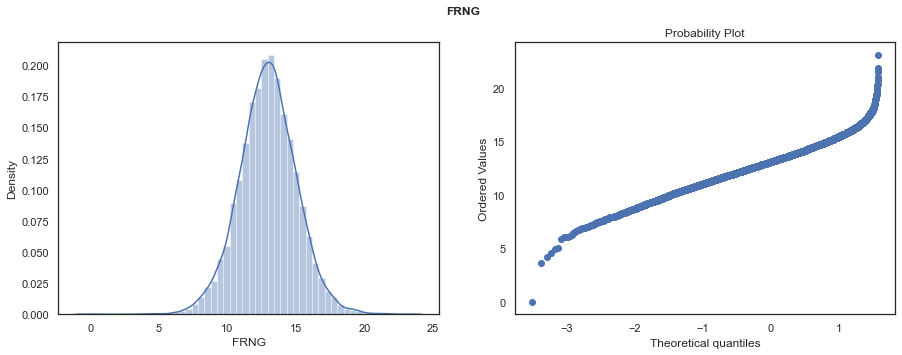

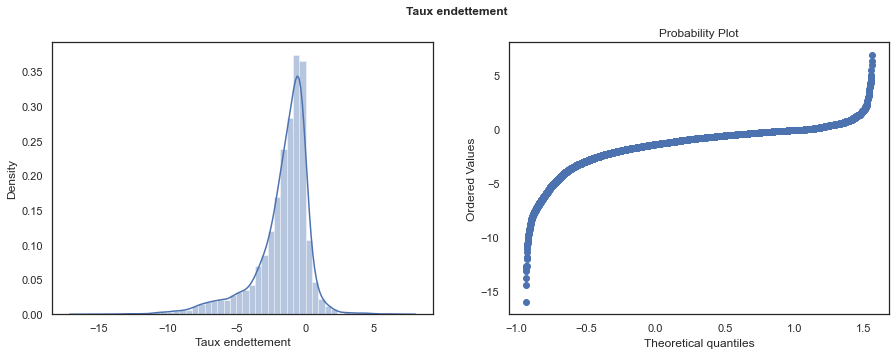

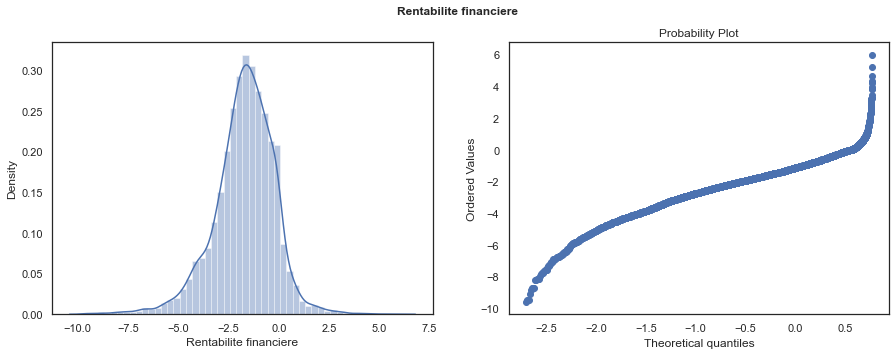

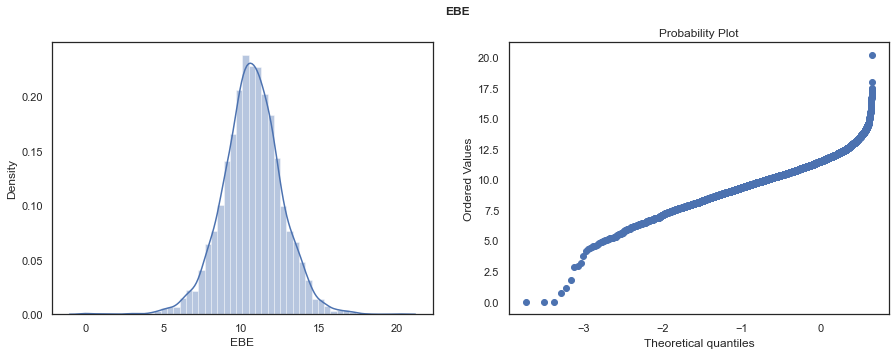

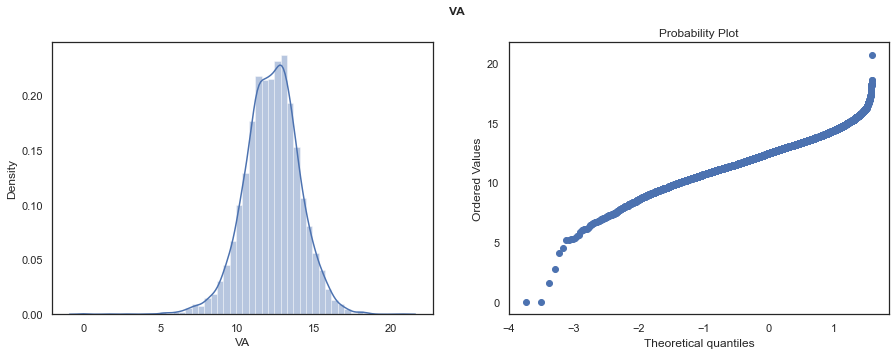

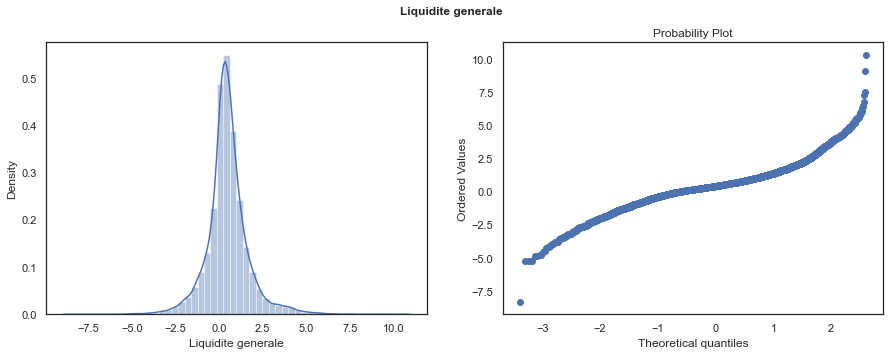

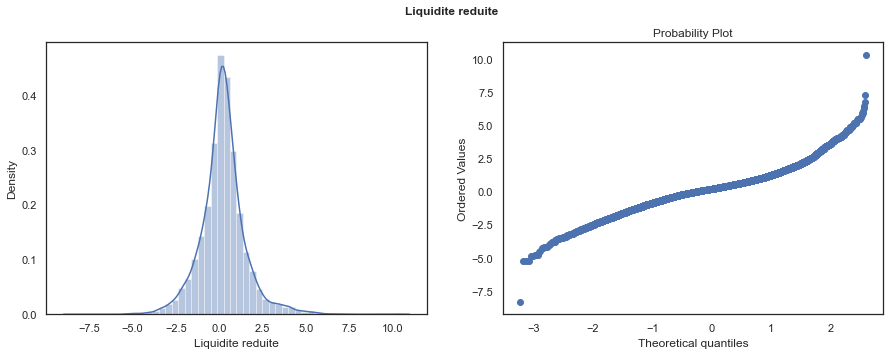

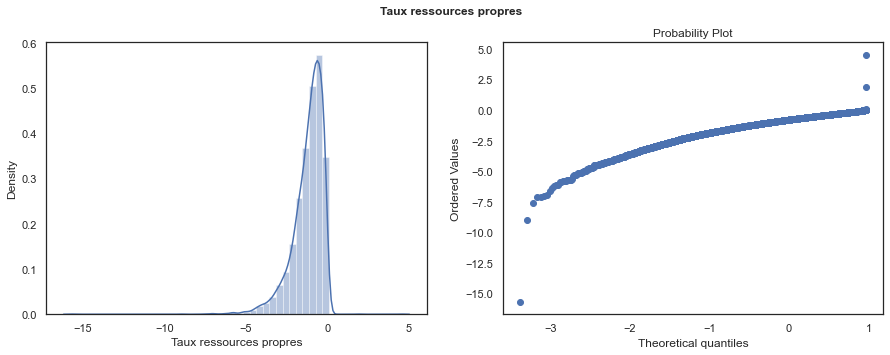

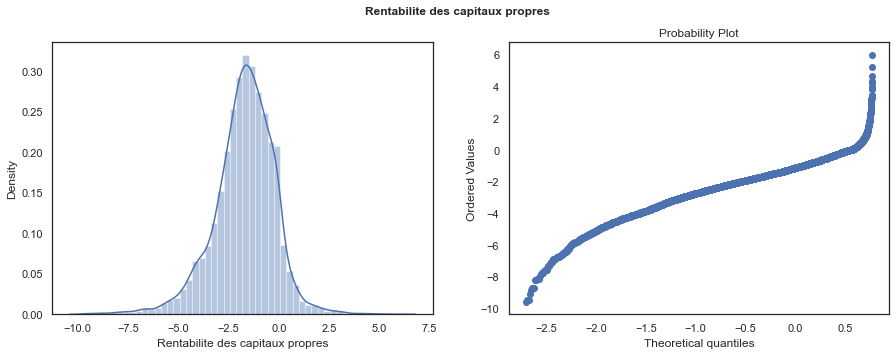

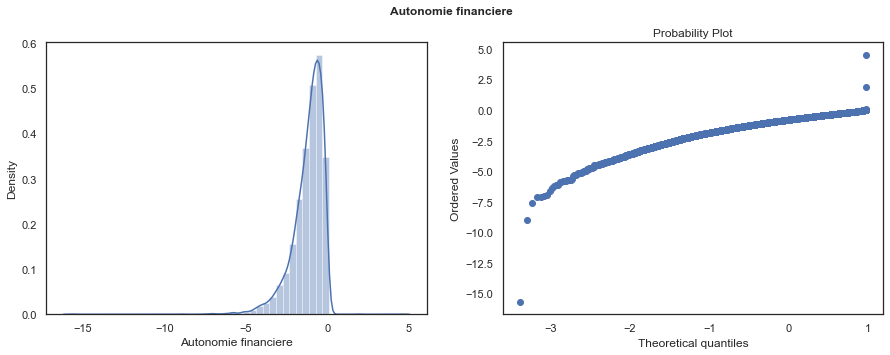

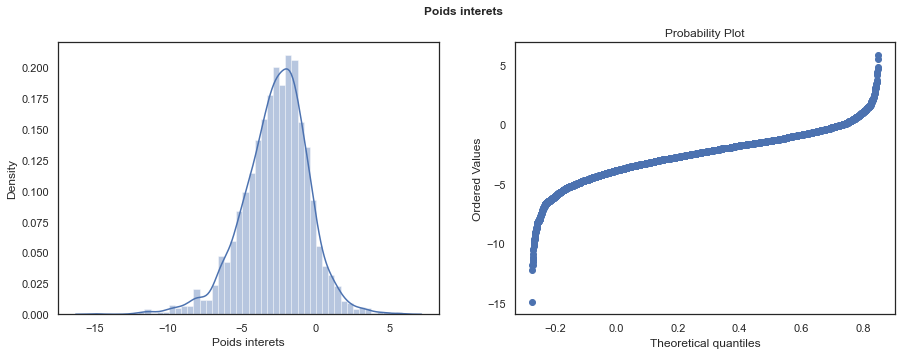

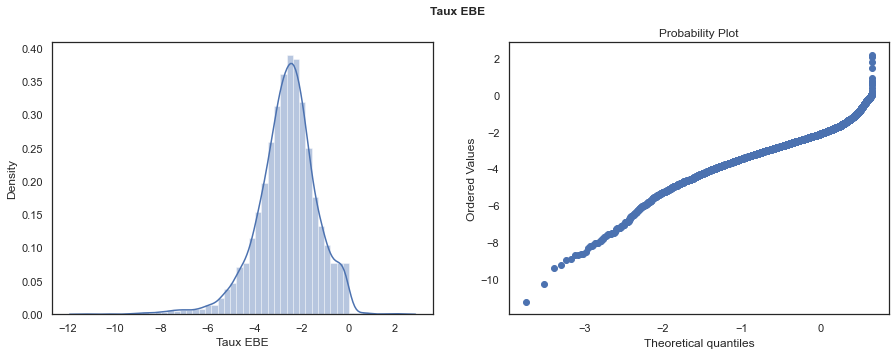

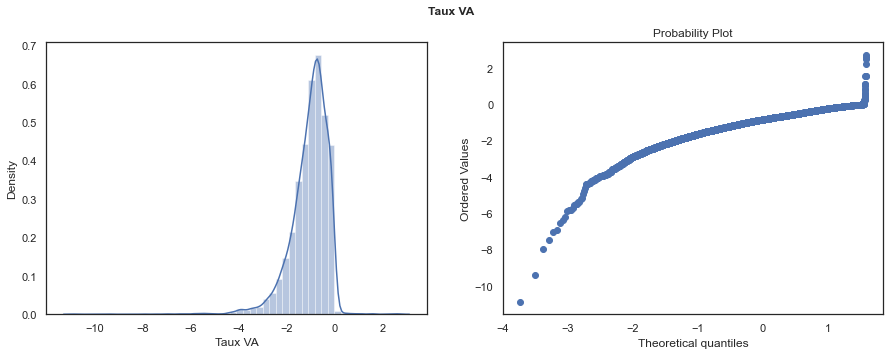

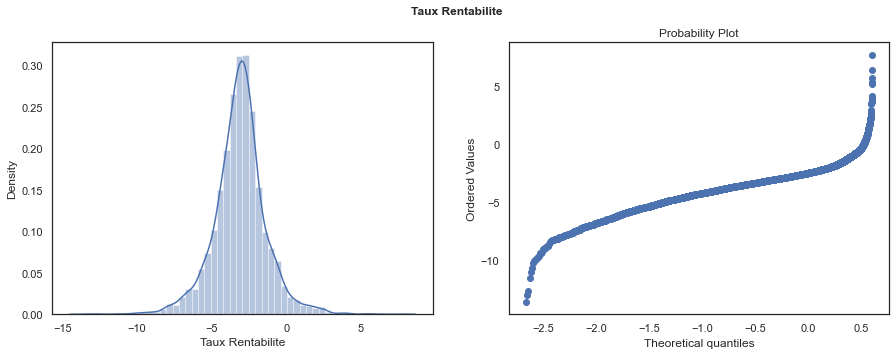

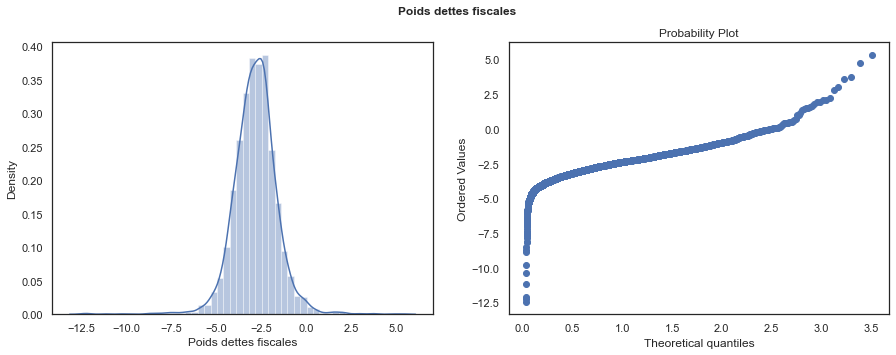

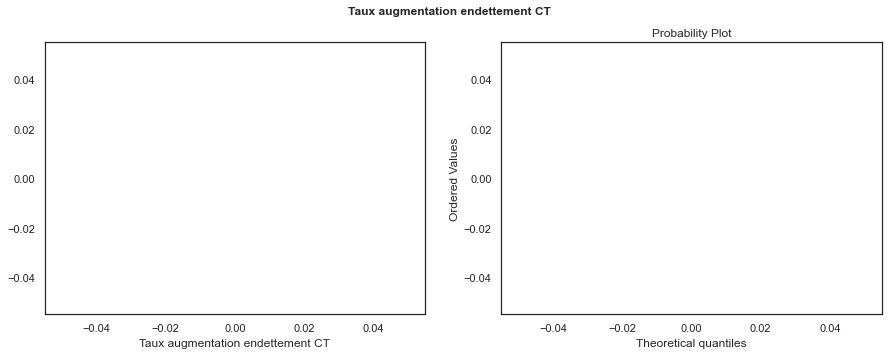

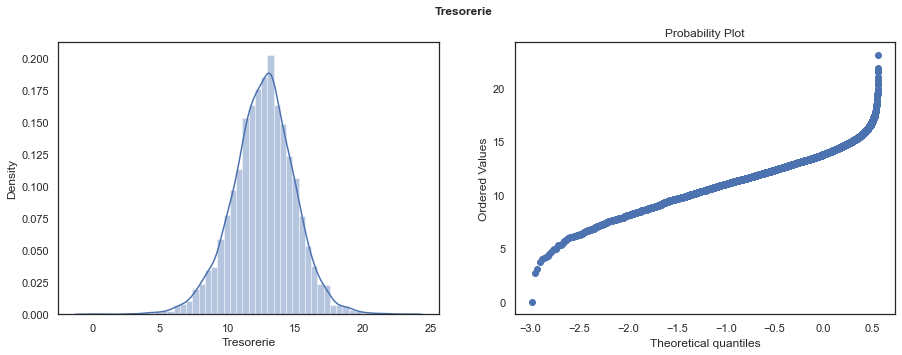

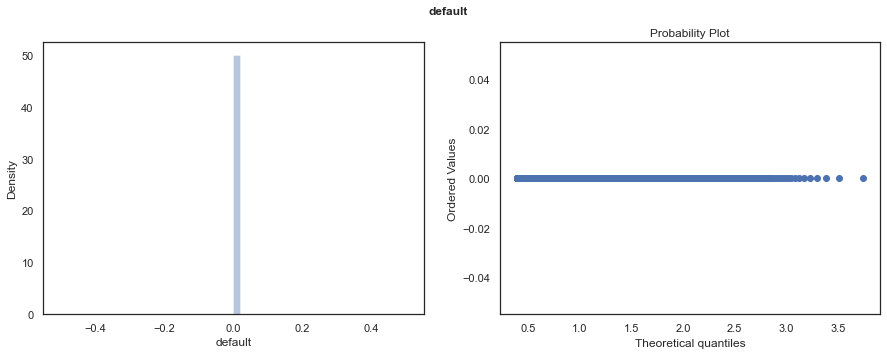

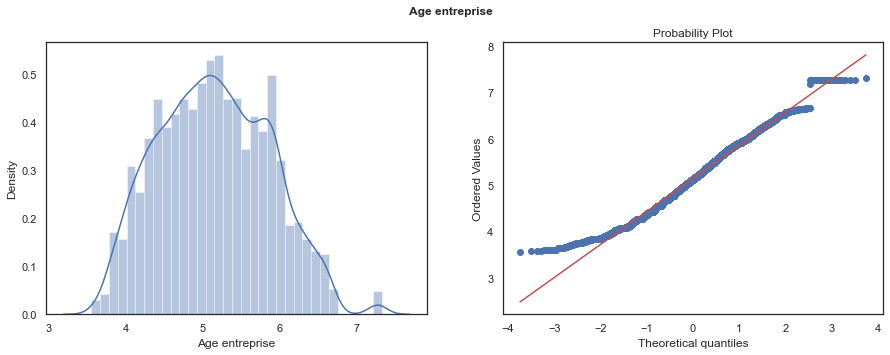

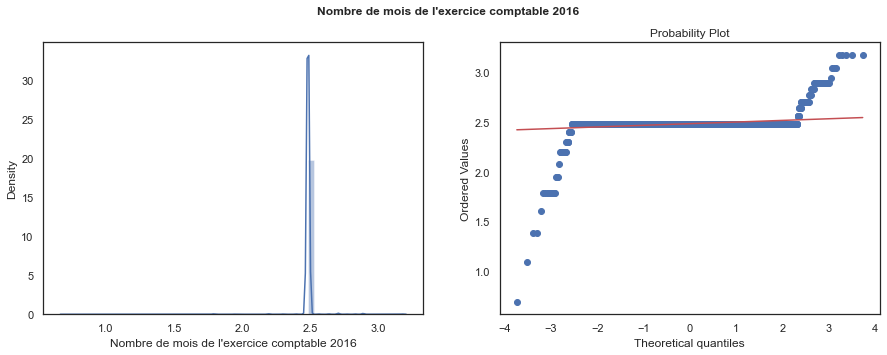

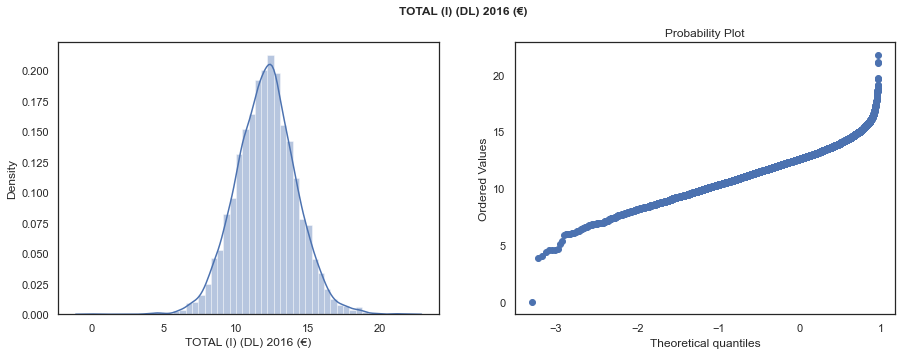

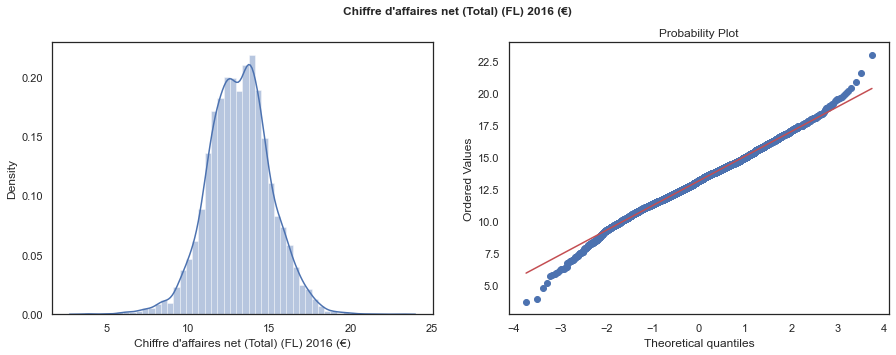

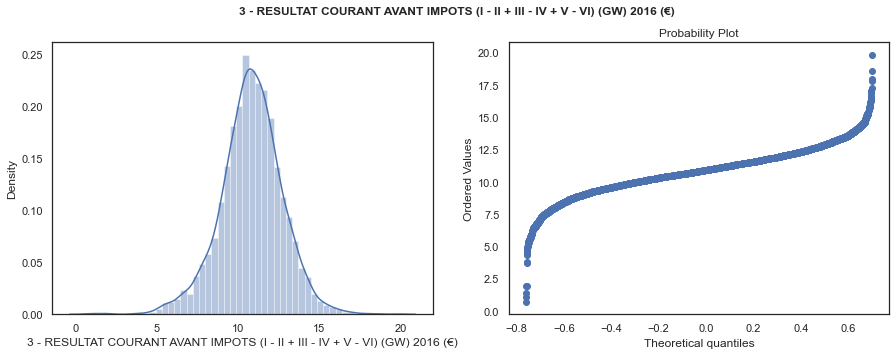

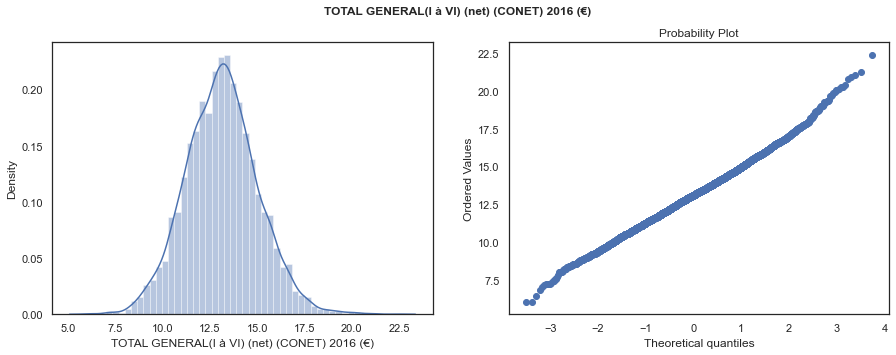

In [69]:
# Histogramme des variables continues
from scipy import stats

for col in eda_log.select_dtypes('number'):
    fig, ((axe1,axe2)) = plt.subplots(nrows=1,ncols=2, figsize = (15,5))
    fig.suptitle(f'{col}', fontsize=12,fontweight="bold")
    
    #sns.histplot(data=eda2, x=col, ax=axe1)
    sns.distplot(eda_log[col], ax=axe1)
    #axe1.set_title('Distribution',fontstyle='italic',fontsize= font_size_title)
    #axe1.set_xlabel('Montant du tips en $', fontsize= font_size_axis)
    #axe1.set_ylabel('Nombre de tips', fontsize= font_size_axis)
    
    stats.probplot(eda_log[col], plot=sns.mpl.pyplot)

- Problème de la transformation en logs => ne marche pas sur les 0 ou les valeurs négatives
- Si on veut conserver la transformation en logs : ajouter une constante à toutes les données (mais si j'ai des ratios ?). 
    - Soit la constante 1, 
    - soit la constante corresondant à x/2, x étant la plus petite valeur non nulle observée dans le dataset)
    - I prefer to apply log(X - (min(X) - 1)) to eliminate log0 and negativity problems
    - Sur les ratios : if your data were ratio data, the only transformations you could make would be multiplicative transformations, because adding a constant destroys the rational zero. However, because your data are interval, any linear transformation is fine--according to Keith Widaman in a lecture he gave at UC Davis. If your data were ratio (i.e., did have an absolute zero), you could use the square root transformation rather than a log+1 transformation.
- Sinon on a d'autres options :
    - lae passage en racine carrée (mais marche surtout pour des distributions avec slight right skew
    - la box-cox transformation (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html)

Use Box-Cox transformation for data having zero values.This works fine with zeros (although not with negative values). However, often the square root is not a strong enough transformation to deal with the high levels of skewness (we generally do sqrt transformation for right skewed distribution) seen in real data. If you are using are than can use function boxcox.fit() in package named geoR.

In [ ]:
# total de NaN sur le dataset
eda_log.isna().sum().sum()/(eda_log.shape[0]*eda_log.shape[1])*100

In [ ]:
# taux de NaN par colonne
(eda_log.isna().sum()/eda_log.shape[0]).sort_values(ascending=False)

### Deuxième essai : un passage de tout le dataset en racine carrée

In [ ]:
eda_root = np.sqrt(eda2_num)

In [ ]:
# taux de NaN par colonne
(eda_root.isna().sum()/eda_root.shape[0]).sort_values(ascending=False)

In [ ]:
# fonction de récap infos sur df
def df_info(df):
        len_df = len(df)
        all_columns = len(df.columns)
        all_nan = df.isna().sum().sum()
        list_of_numerics = df.select_dtypes(include = ['float','int']).columns
        print(f"""
        Longueur du dataset : {len_df} enregistrements
        Nombre de colonnes : {all_columns}
        """)
        echantillonColonnes = []
        for i in df.columns:
            listcolumn = str(list(df[i].head(5)))
            echantillonColonnes.append(listcolumn)
        obs = pd.DataFrame({'type': list(df.dtypes),
        'Echantillon': echantillonColonnes,
        "% de valeurs nulles":
        round(df.isna().sum() / len_df * 100, 2),
                            "% de valeurs négatives":
        'Nbr L dupliquées' : (df.duplicated()).sum(),
        'Nbr V unique' : df.nunique(),
        'Nbr Outliers' : df.apply(lambda x: sum(
                                 (x<(x.quantile(0.25) - 1.5 * (x.quantile(0.75)-x.quantile(0.25)))) |
                                 (x>(x.quantile(0.75) + 1.5 * (x.quantile(0.75)-x.quantile(0.25))))
                                 if x.name in list_of_numerics else ''))
        })
        return obs

In [ ]:
eda2_num.columns

In [ ]:
eda2_num.describe()

### Focus sur les données nulles et négatives

In [ ]:
#compter les valeurs négatives et les afficher dans un heatmap
# afficher le % de valeurs négatives et les afficher dans le résumé
# afficher, pour chaque colonne, seulement la distribution des valeurs négatives ou nulles




In [ ]:
for col in eda2_num.columns:
    plt.figure()
    sns.displot(x=eda2_num[col][eda2_num[col] < 0])
    plt.show()

In [ ]:
montants = ['Credit client', 'Credit Fournisseurs', 'Rotation_stocks', 'BFR', 'BFRE', 
            'Endettement total', 'CAF', 'Ressources durables', 'FRNG', 'EBE', 'VA',
           'Tresorerie', 'default', 'Age entreprise', "Nombre de mois de l'exercice comptable 2016",
            'TOTAL (I) (DL) 2016 (€)', "Chiffre d'affaires net (Total) (FL) 2016 (€)", 
            '3 - RESULTAT COURANT AVANT IMPOTS (I - II + III - IV + V - VI) (GW) 2016 (€)', 
            'TOTAL GENERAL(I à VI) (net) (CONET) 2016 (€)']
ratios = ['Taux endettement', 'Rentabilite financiere','Taux ressources propres', 
          'Rentabilite des capitaux propres', 'Autonomie financiere', 'Poids interets', 
          'Taux EBE', 'Taux VA', 'Taux Rentabilite', 'Poids dettes fiscales', 
          'Taux augmentation endettement CT']
ne_pas_transformer = ['default', 'Age entreprise', "Nombre de mois de l'exercice comptable 2016"]

In [ ]:
df_info(eda2_num)

In [ ]:
# Histogramme des variables continues
for col in eda2.select_dtypes('number'):
    plt.figure()
    sns.histplot(eda2[col], stat="density")
    #sns.distplot(df[col])
    #sns.
    # rajouter qq plot
    # rajouter lien avec la target ?

In [ ]:
fig, ((axe1,axe2),(axe3,axe4)) = plt.subplots(nrows=2,ncols=2, figsize = (15,18))

font_size_title = 16
font_size_axis = 12

fig.suptitle('Analyse du jeu de donnée tips de Seaborn', fontsize=18,fontweight="extra bold")

sns.histplot(data=data, x='tip', ax=axe1)
axe1.set_title('Distribution du montant des tips',fontstyle='italic',fontsize= font_size_title)
axe1.set_xlabel('Montant du tips en $', fontsize= font_size_axis)
axe1.set_ylabel('Nombre de tips', fontsize= font_size_axis)


axe2.scatter(x='total_bill', y='tip', data=data,c='red')
axe2.set_title("Correlation entre \n le montant du tips et le montant de l'addition",fontstyle='italic',fontsize= font_size_title)
axe2.set_xlabel("Montant de l'addition en $", fontsize= font_size_axis)
axe2.set_ylabel("Montant du tips en $", fontsize= font_size_axis)


axe3.scatter(x='day',y='tip',data=data, color='green')
axe3.set_title('Repartition du montant du pourboire \npar rapport au jour',fontstyle='italic',fontsize= font_size_title)
axe3.set_xlabel("Jours", fontsize= font_size_axis)
axe3.set_ylabel("Montant du tips en $", fontsize= font_size_axis)
axe3.set_yticks([2,4,6,8,10])
axe3.set_yticklabels(['2 $','4 $','6 $','8 $','10 $'])



sns.regplot(x='size', y='tip', data=data, ax=axe4, color='black', ci=95)
axe4.set_title('Montant du tips en fonction \ndu nombre de personne à la table',fontstyle='italic',fontsize= font_size_title)
axe4.set_xlabel("Nombre de personne à une table", fontsize= font_size_axis)
axe4.set_ylabel("Montant du tips en $", fontsize= font_size_axis)

for axe in [axe1,axe2,axe3,axe4]:
    remove_spines(axe)

plt.show()

# PLOTLY

In [ ]:
import plotly.express as px
fig = px.bar(x=["a", "b", "c"], y=[1, 3, 2])
fig.show()

In [ ]:
import plotly.express as px
df = px.data.tips()
fig = px.histogram(df, x="total_bill", y="tip", color="sex", marginal="rug", hover_data=df.columns)
fig.show()

In [ ]:
eda2.columns

In [ ]:
for col in eda2.select_dtypes('number'):
    fig = px.histogram(eda2, x=eda2[col], color="default", nbins=6000, histnorm='probability density', marginal="box")
    fig.update_traces(opacity=0.6)
    fig.show()